# COGS 108 - Final Project

# Crime n' Booze: 
## an analytical exploration of crime rates and alcohol availability in San Diego County

### The team: ***Jenny Hamer, Aparna Rangamani, Jairo Chavez***

### Our Question:
#### I) Is there an association between the rates of particular types of crime and the availability of alcohol?
#### II) Is this consistent across cities in San Diego County?

### Our Hypothesis:
#### We predict to find an association - more precisely, a positive correlation - between alcohol availability and overall crime rates (per capita). Furthermore, we expect these findings to be consistent across cities within SD County.

### Why we cared:
Alcohol is arguably the most socially acceptable drug in San Diego; however, it has the potential to negatively impact individuals and communities in various ways. One of the most important of these is crime, and that leads us to wonder if alcohol abundance or restriction might impact its interrelation with crime.

According to the National Council on Alcoholism and Drug Dependence, "alcohol and drugs are implicated in an estimated 80% of offenses leading to incarceration in the United States such as domestic violence, driving while intoxicated, property offenses, drug offenses, and public-order offenses." We want to examine how San Diego county is affected by the legal availability of alcohol (ie. from liquor markets, grocery stores, restaurants, hotels) and the rates of crimes in the area (particularly those commonly associated with excessive alcohol use; the Alcohol Rehab Guide lists robbery, sexual assault, child abuses as examples).

### Our Data:
#### We address these questions by examining a recent, inclusive 5-year span (from 2008 - 2012)
#### I. Crimes categorized by Type and by City (consisting of roughly 750,000 records) 
(data from SANDAG and San Diego Data: http://data.sandiegodata.org/dataset/clarinova_com-crime-incidents-casnd-7ba4-extract)

Thank you, San Diego Data, for composing a fairly nice dataset!

***The Crime Data***: Each crime record contains a "city", "community", and "neighborhood" (as well as "type" and a more detailed "description" describing the nature of the crime itself). After performing various analyses, using the more granular "community", we realized that this categorization conflicted with our other dataset's locational specifiers. We ultimately categorized these records by "city". To clarify (in case you're not an SD local), these are places such as Oceanside, Encinitas, Chula Vista, Escondido, Del Mar, the City of San Diego, etc.
Some popular crime "types" include: ASSAULT, DRUGS/ALCOHOL VIOLATIONS, THEFT, BURGLARY, DUI, ROBBERY, SEX CRIMES, ARSON, HOMICIDE, etc.

#### I.i A random sampling of Crimes from the same 5-year span (100,000 records)

This dataset is a subset of ****No. I**** (from the same host): it is categorized by "communities" within San Diego City itself. We've included this and a preliminary analysis as a "teaser" of finer granularity of crime rates examined within smaller geographical areas.

#### II. Alcohol Permits (also known as ABC - Alcohol Beverage Control licenses; just shy of 5,000 permits) 
(data from San Diego Data: http://data.sandiegodata.org/dataset/clarinova_com-alcohol_licenses-casnd-429e-extract - nearly 5000 datapoints)

***The Booze Data***: For each permit, which specified a Business or Purveyor, included longitude, latitude coordinates; we used these for geospatial analysis (as it facilitated the plotting of points on our map), however this was not well suited for analysis! Therefore, as each record also contained a full address, we extracted the "city" from this for more consistent classification with matched a categorizing option from the ****Crime**** data. We verified that none of these expired prior to the year 2012.


### Python, Pandas, Numpy, oh my!

In [1]:
# INCLUDE ALL IMPORTS HERE (REMOVE THIS COMMENT WHEN FINISHED, but leave the one right below it)

# to prettify:
% reset
% config InlineBackend.figure_format = 'retina'
% matplotlib inline

# data processing & analysis packages: 
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
from scipy import stats

# data visualization packages: for plotting, geospatial analyzes, and more...
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import geocoder
import folium

# also to prettify:
rcParams['figure.figsize'] = [15, 15]
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
sns.set(style='whitegrid', context ='paper')

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Data Cleaning & Preprocessing

In [2]:
# our five-year crime dataset --> into a dataframe: df_crime
# the boose data --> load that badboy into: df_alcohol

df_crime = pd.read_csv("incidents-5y.csv")
df_alcohol = pd.read_csv("abc_licenses_sdcounty.csv")
aggregate_df = pd.read_csv("aggregate_dataset_5y.csv")

In [3]:
#get a glimpse of the crime data
df_crime.head()

,id,date,year,month,day,week,dow,time,hour,is_night,...,comm_pop,council,council_pop,asr_zone,lampdist,lat,lon,desc,gctype,gcquality
0,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,33.137756,-117.266499,PETTY THEFT,cns/segment,65
1,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.630291,-117.004355,FRAUD,cns/segment,65
2,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,33.193405,-117.316456,FRAUD,cns/segment,22
3,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.655955,-116.958372,FRAUD,cns/segment,65
4,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,1,...,0,NONE,0,NaN,NaN,32.626110,-117.079400,FRAUD,cns/segment,65


In [4]:
# our data is very high dimensional, as can be seen above
# here is an overview of the number of cities represented by the dataset 
# and the relative frequencies of crimes in each
df_crime['city'].value_counts()

SndSAN    362073
SndSDO    134022
SndCHU     48927
SndOCN     46505
SndESC     37038
SndELC     26305
SndVIS     24068
SndNAT     19118
SndCAR     18141
SndLAM     15770
SndSNM     13700
SndENC     11306
SndSNT     11123
SndPOW      6903
SndIMP      6813
SndLEM      6221
SndCOR      4922
SndDEL      2670
SndSOL      2353
Name: city, dtype: int64

In [5]:
# SndCHU sure looks a lot like Chula Vista, but is it? Same goes with SndSOL and Solana Beach.
# we will use a small dataset from SANDAG (the same resource used for the crime dataset) to get the city names
df_code = pd.read_csv('city_codes.csv')
df_code.head()

,type,code,code v2,scode,name,lon,lat,area
0,city,SndSDO,CaSanSDC,CN,S.D. County,-116.658688,33.059591,9.949928e+10
1,city,SndSAN,CaSanSAN,SD,San Diego,-117.122705,32.830321,9.551285e+09
2,city,SndCHU,CaSanCHU,CV,Chula Vista,-117.014424,32.628103,1.453371e+09
3,city,SndOCN,CaSanOCN,OC,Oceanside,-117.308368,33.224657,1.175111e+09
4,city,SndPOW,CaSanPOW,PW,Poway,-117.020127,32.987160,1.090701e+09


In [6]:
# some code to go from the city code to the city name
# the general logic is to get the city code for each row, find its name in the df_code dataset, and return it!

# a function defintion- here is where the magic happens
def get_city_name(row):
    city_code = row['city']
    df_city_name = df_code.loc[df_code['code'] == city_code, 'name']
    city_name = df_city_name.to_string(index=False)
    return city_name

# we create a new column in our original dataframe that contains the full city name for each row.
#df_crime['city_name'] = df_crime.apply(get_city_name, axis=1)

# N.B. this step is very time expensive (about 30 minutes), for we are adding a new entry for over 750,000 rows
# we therefore have exported df_crime into a .csv file, to avoid having to recompute the dataframe
df_crime = pd.read_csv('crime_data.csv')

# we now admire our new column in df_crime
df_crime.head()

,Unnamed: 0,id,date,year,month,day,week,dow,time,hour,...,council,council_pop,asr_zone,lampdist,lat,lon,desc,gctype,gcquality,city_name
0,0,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,...,NONE,0,NaN,NaN,33.137756,-117.266499,PETTY THEFT,cns/segment,65,Carlsbad
1,1,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,...,NONE,0,NaN,NaN,32.630291,-117.004355,FRAUD,cns/segment,65,Chula Vista
2,2,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,...,NONE,0,NaN,NaN,33.193405,-117.316456,FRAUD,cns/segment,22,Oceanside
3,3,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,...,NONE,0,NaN,NaN,32.655955,-116.958372,FRAUD,cns/segment,65,Chula Vista
4,4,NaN,2008-01-01,2008,1,2922,0,2,00:00:00,0,...,NONE,0,NaN,NaN,32.626110,-117.079400,FRAUD,cns/segment,65,Chula Vista


In [7]:
# we now turn to fixing up the ABC licenses dataset
# our general goal is once again to determine the full city name for each ABC license location
# that way, we will have a common standard by which to compare the crime and the ABC license data

# we first preview our ABC license data
df_alcohol.head()

,last_date,OGC_FID,GEOMETRY,licenses_id,scrape_date,licenseno,status,licensetype,issuedate,exprdate,...,y,city,neighborhood,community,council,tract,business,mailaddress,gcquality,gctype
0,2013-07-09T,1,NaN,NaN,2013-07-09T,413,ACTIVE,51,1951-07-20T,2014-03-31T,...,1.864266e+06,NONE,NONE,NONE,NONE,0076.00,NaN,NaN,0,cns/address
1,2013-07-09T,2,NaN,NaN,2013-07-09T,1414,ACTIVE,41,1978-06-05T,2014-04-30T,...,1.914461e+06,SndSAN,NONE,NONE,NONE,0083.59,Capriccio Italian Restaurant,NaN,0,cns/address
2,2013-07-09T,3,NaN,NaN,2013-07-09T,1419,ACTIVE,21,1964-08-18T,2013-09-30T,...,1.836128e+06,SndCHU,NONE,NONE,NONE,0035.01,Ocean View Liquor,NaN,0,cns/address
3,2013-07-09T,4,NaN,NaN,2013-07-09T,2498,ACTIVE,21,1978-01-01T,2013-08-31T,...,1.853602e+06,SndOCN,NONE,NONE,NONE,0024.01,Market Place The,NaN,0,cns/address
4,2013-07-09T,5,NaN,NaN,2013-07-09T,3803,ACTIVE,48,1977-05-18T,2014-03-31T,...,1.872476e+06,SndPOW,NONE,NONE,NONE,0079.08,Silver Fox Associates Inc,NaN,0,cns/address


In [8]:
# how unfortunate- the "neighborhood" and "community" columns, seemingly so helpful, are almost all NONE :/
# we quickly check whether the same is true for the "city" column
print( 'Ratio of no. of NONE entries to no. of ABC licenses' )
len( df_alcohol[df_alcohol['city'] == 'NONE'] ) / len( df_alcohol )

Ratio of no. of NONE entries to no. of ABC licenses


0.9963906156005614

In [9]:
# alas, we need to find another way.
# our solution: extract the city name from the address!

# the "city" column is essentially useless, so we drop it to make it unhelpfulness official
df_alcohol = df_alcohol.drop(['city'], 1)

# a function definition- here is where the hard work happens
# the general logic is to get the address for each row and do some pythonic string operations to return the city name
import copy
def get_city(row):
    address = row['premisesaddress']
    address_components = address.split(", ")
    string = address_components[-2].title()
    city_name = copy.deepcopy(string)
    return city_name

# we dedicate a column in the df_alcohol dataframe to storing the full city name
df_alcohol['city_name'] = df_alcohol.apply(get_city, axis=1)

# we can see our new column below
df_alcohol.head()

,last_date,OGC_FID,GEOMETRY,licenses_id,scrape_date,licenseno,status,licensetype,issuedate,exprdate,...,y,neighborhood,community,council,tract,business,mailaddress,gcquality,gctype,city_name
0,2013-07-09T,1,NaN,NaN,2013-07-09T,413,ACTIVE,51,1951-07-20T,2014-03-31T,...,1.864266e+06,NONE,NONE,NONE,0076.00,NaN,NaN,0,cns/address,San Diego
1,2013-07-09T,2,NaN,NaN,2013-07-09T,1414,ACTIVE,41,1978-06-05T,2014-04-30T,...,1.914461e+06,NONE,NONE,NONE,0083.59,Capriccio Italian Restaurant,NaN,0,cns/address,San Diego
2,2013-07-09T,3,NaN,NaN,2013-07-09T,1419,ACTIVE,21,1964-08-18T,2013-09-30T,...,1.836128e+06,NONE,NONE,NONE,0035.01,Ocean View Liquor,NaN,0,cns/address,San Diego
3,2013-07-09T,4,NaN,NaN,2013-07-09T,2498,ACTIVE,21,1978-01-01T,2013-08-31T,...,1.853602e+06,NONE,NONE,NONE,0024.01,Market Place The,NaN,0,cns/address,San Diego
4,2013-07-09T,5,NaN,NaN,2013-07-09T,3803,ACTIVE,48,1977-05-18T,2014-03-31T,...,1.872476e+06,NONE,NONE,NONE,0079.08,Silver Fox Associates Inc,NaN,0,cns/address,San Diego


In [10]:
# we list out the cities in both dataframes to see whether they are in fact identical
print("cities in crime dataset")
list_crimecities = df_crime['city_name'].unique().tolist()
print("cities in alcohol dataset")
list_alcoholcities = df_alcohol['city_name'].unique().tolist()

print("Are the cities in both dataframes identical?")
print( "That is %s" % list_crimecities == list_alcoholcities )
print( "Number of cities in crime df: %d" % len(list_crimecities) )
print( "Number of cities in ABC licenses df: %d" % len(list_alcoholcities))

# we display the list of cities to do a visual comparison
print("cities in crime dataset")
print(list_crimecities) 
print("cities in alcohol dataset")
print(list_alcoholcities)

cities in crime dataset
cities in alcohol dataset
Are the cities in both dataframes identical?
False
Number of cities in crime df: 19
Number of cities in ABC licenses df: 18
cities in crime dataset
['Carlsbad', 'Chula Vista', 'Oceanside', 'El Cajon', 'La Mesa', 'San Diego', 'S.D. County', 'Escondido', 'National City', 'Imperial Beach', 'San Marcos', 'Vista', 'Lemon Grove', 'Encinitas', 'Poway', 'Solana Beach', 'Santee', 'Coronado', 'Del Mar']
cities in alcohol dataset
['San Diego', 'National City', 'Del Mar', 'Escondido', 'Encinitas', 'Imperial Beach', 'Oceanside', 'Lemon Grove', 'Carlsbad', 'Chula Vista', 'El Cajon', 'Vista', 'La Mesa', 'Santee', 'Poway', 'Coronado', 'Solana Beach', 'San Marcos']


In [11]:
# we remove S.D. County from dataframe as is not represented in the ABC licenses data
df_crime = df_crime[df_crime['city_name'] != 'S.D. County']

# we confirm the list of cities is the same now
list_crimecities = df_crime['city_name'].unique().tolist()
list_alcoholcities = df_alcohol['city_name'].unique().tolist()
print("Are the cities in both dataframes identical?")
print( "That is %s" % list_crimecities == list_alcoholcities )

Are the cities in both dataframes identical?
False


In [12]:
# now we are ready to merge our data for both crime and alcohol together!

# we determine the number of crimes and ABC licneses that occur for each city
crime_counts = df_crime['city_name'].value_counts()
alcohol_counts = df_alcohol['city_name'].value_counts()

# function definition- here is where we get the total number of crimes for each city
def get_total_crime(row):
    city_name = row['city_name']
    return crime_counts[city_name]

# function definition- here is where we get the total number of ABC licenses for each city
def get_total_alcohol(row):
    city_name = row['city_name']
    return alcohol_counts[city_name]

# we establish our first column in the aggregate dataframe
# the city names will be unique so there will be 18 rows total
df = df_alcohol.loc[:, ['city_name']].drop_duplicates()

# we determine the number of crimes and ABC licenses for each city
df.loc[:,'total_crime'] = df.apply(get_total_crime, axis=1)
df.loc[:, 'total_alcohol'] = df.apply(get_total_alcohol, axis=1)

# we can see our new dataframe coming together!
df

,city_name,total_crime,total_alcohol
0,San Diego,362073,2661
7,National City,19118,102
8,Del Mar,2670,36
10,Escondido,37038,256
12,Encinitas,11306,157
19,Imperial Beach,6813,48
20,Oceanside,46505,258
22,Lemon Grove,6221,36
23,Carlsbad,18141,185
27,Chula Vista,48927,291


In [13]:
# now we refine our data further!
# we determine the population for each city to normalize our alcohol and crime counts

# because of the lack of a clean dataset and the relatively small number of cities, we decided to hard code 
# the values by hand. long-term that is not the best practice, but for the short-term it worked for us
# source: U.S. Census Bureau 2010- http://www.togetherweteach.com/TWTIC/uscityinfo/05ca/capopr/05capr.html
df['city_pop'] = [1307402, 58582, 4161, 143191, 59518, 26324, 167086, 25320, 
                 105328, 243916, 99478, 93834, 57065, 53413, 47811, 18912,
                12867, 83781]

In [14]:
# now we fine-tune our crime counts even more, to differentiate them by type along with sheer number!

# we collect relevant data for the types of crimes and the city names from the original dataset
df_crime_type = df_crime[['city_name', 'type']]

# here is a preview of the types of crimes and their frequency 
# counts are not segregated by city yet. that will be our next job
df_stat = df_crime_type['type'].value_counts()
df_stat

DRUGS/ALCOHOL VIOLATIONS    146198
THEFT/LARCENY                94975
VEHICLE BREAK-IN/THEFT       83602
BURGLARY                     61597
MOTOR VEHICLE THEFT          59946
VANDALISM                    54654
ASSAULT                      53085
FRAUD                        37064
DUI                          35408
ROBBERY                      14588
SEX CRIMES                   14237
WEAPONS                       6873
ARSON                         1429
HOMICIDE                       300
Name: type, dtype: int64

In [15]:
# first, we convert 'type' column in df_crime to lower case
# there is no real reason, just for aesthetic purposes
df_crime['type'] = df_crime['type'].str.lower()

# next, we get a list of the unique crime type names. this will be useful later on.
list_crimetypes = df_crime['type'].drop_duplicates().tolist()

# function definition that returns the number of crimes with a given crimetype that occur for a given city
def get_crimetype_counts(row, crimetype):
    df_crimetype_counts = df_crime.loc[(df_crime['city_name'] == row['city_name']) & (df_crime['type'] == crimetype)]
    return len(df_crimetype_counts)

# we iterate over all the different crime types
for crimetype in list_crimetypes:
    # we determine the total number of crimes with a given crime type that occurs per city 
    # we save the results in a column called crimetype
    df.loc[:, crimetype] = df.apply(get_crimetype_counts, args=(crimetype,), axis=1)

In [16]:
# the data cleaning steps are complete, and we are now ready to admire our finished dataframe!
# for fun, just to make it official, we renname our dataframe as aggregate_df
aggregate_df = df
aggregate_df

,city_name,total_crime,total_alcohol,city_pop,theft/larceny,fraud,assault,sex crimes,vandalism,vehicle break-in/theft,burglary,motor vehicle theft,robbery,drugs/alcohol violations,dui,weapons,arson,homicide
0,San Diego,362073,2661,1307402,48706,19700,29704,7864,27483,44082,32085,35575,8259,85302,18634,3702,793,184
7,National City,19118,102,58582,3960,534,1369,370,1309,1466,1718,2613,817,3775,927,198,50,12
8,Del Mar,2670,36,4161,335,87,208,55,118,311,218,94,26,941,264,12,1,0
10,Escondido,37038,256,143191,4731,2148,2258,1023,3591,5435,3598,3485,731,7691,1761,483,86,17
12,Encinitas,11306,157,59518,1170,638,926,144,674,1905,1157,418,104,2577,1528,58,7,0
19,Imperial Beach,6813,48,26324,433,237,685,131,619,508,534,676,84,2257,521,110,14,4
20,Oceanside,46505,258,167086,7560,2447,3907,1160,6181,5681,3931,2066,730,10516,1737,460,107,22
22,Lemon Grove,6221,36,25320,685,307,612,132,241,444,707,562,217,1819,374,105,13,3
23,Carlsbad,18141,185,105328,3676,617,1437,264,1127,3009,2238,669,208,3562,1185,108,31,10
27,Chula Vista,48927,291,243916,8311,4553,3094,947,5031,6710,4302,6153,1196,5611,2406,471,123,19


### Data Analysis & Some Visualization: All five years of crime in San Diego County by City and Type
Spots on plots and more await you below...

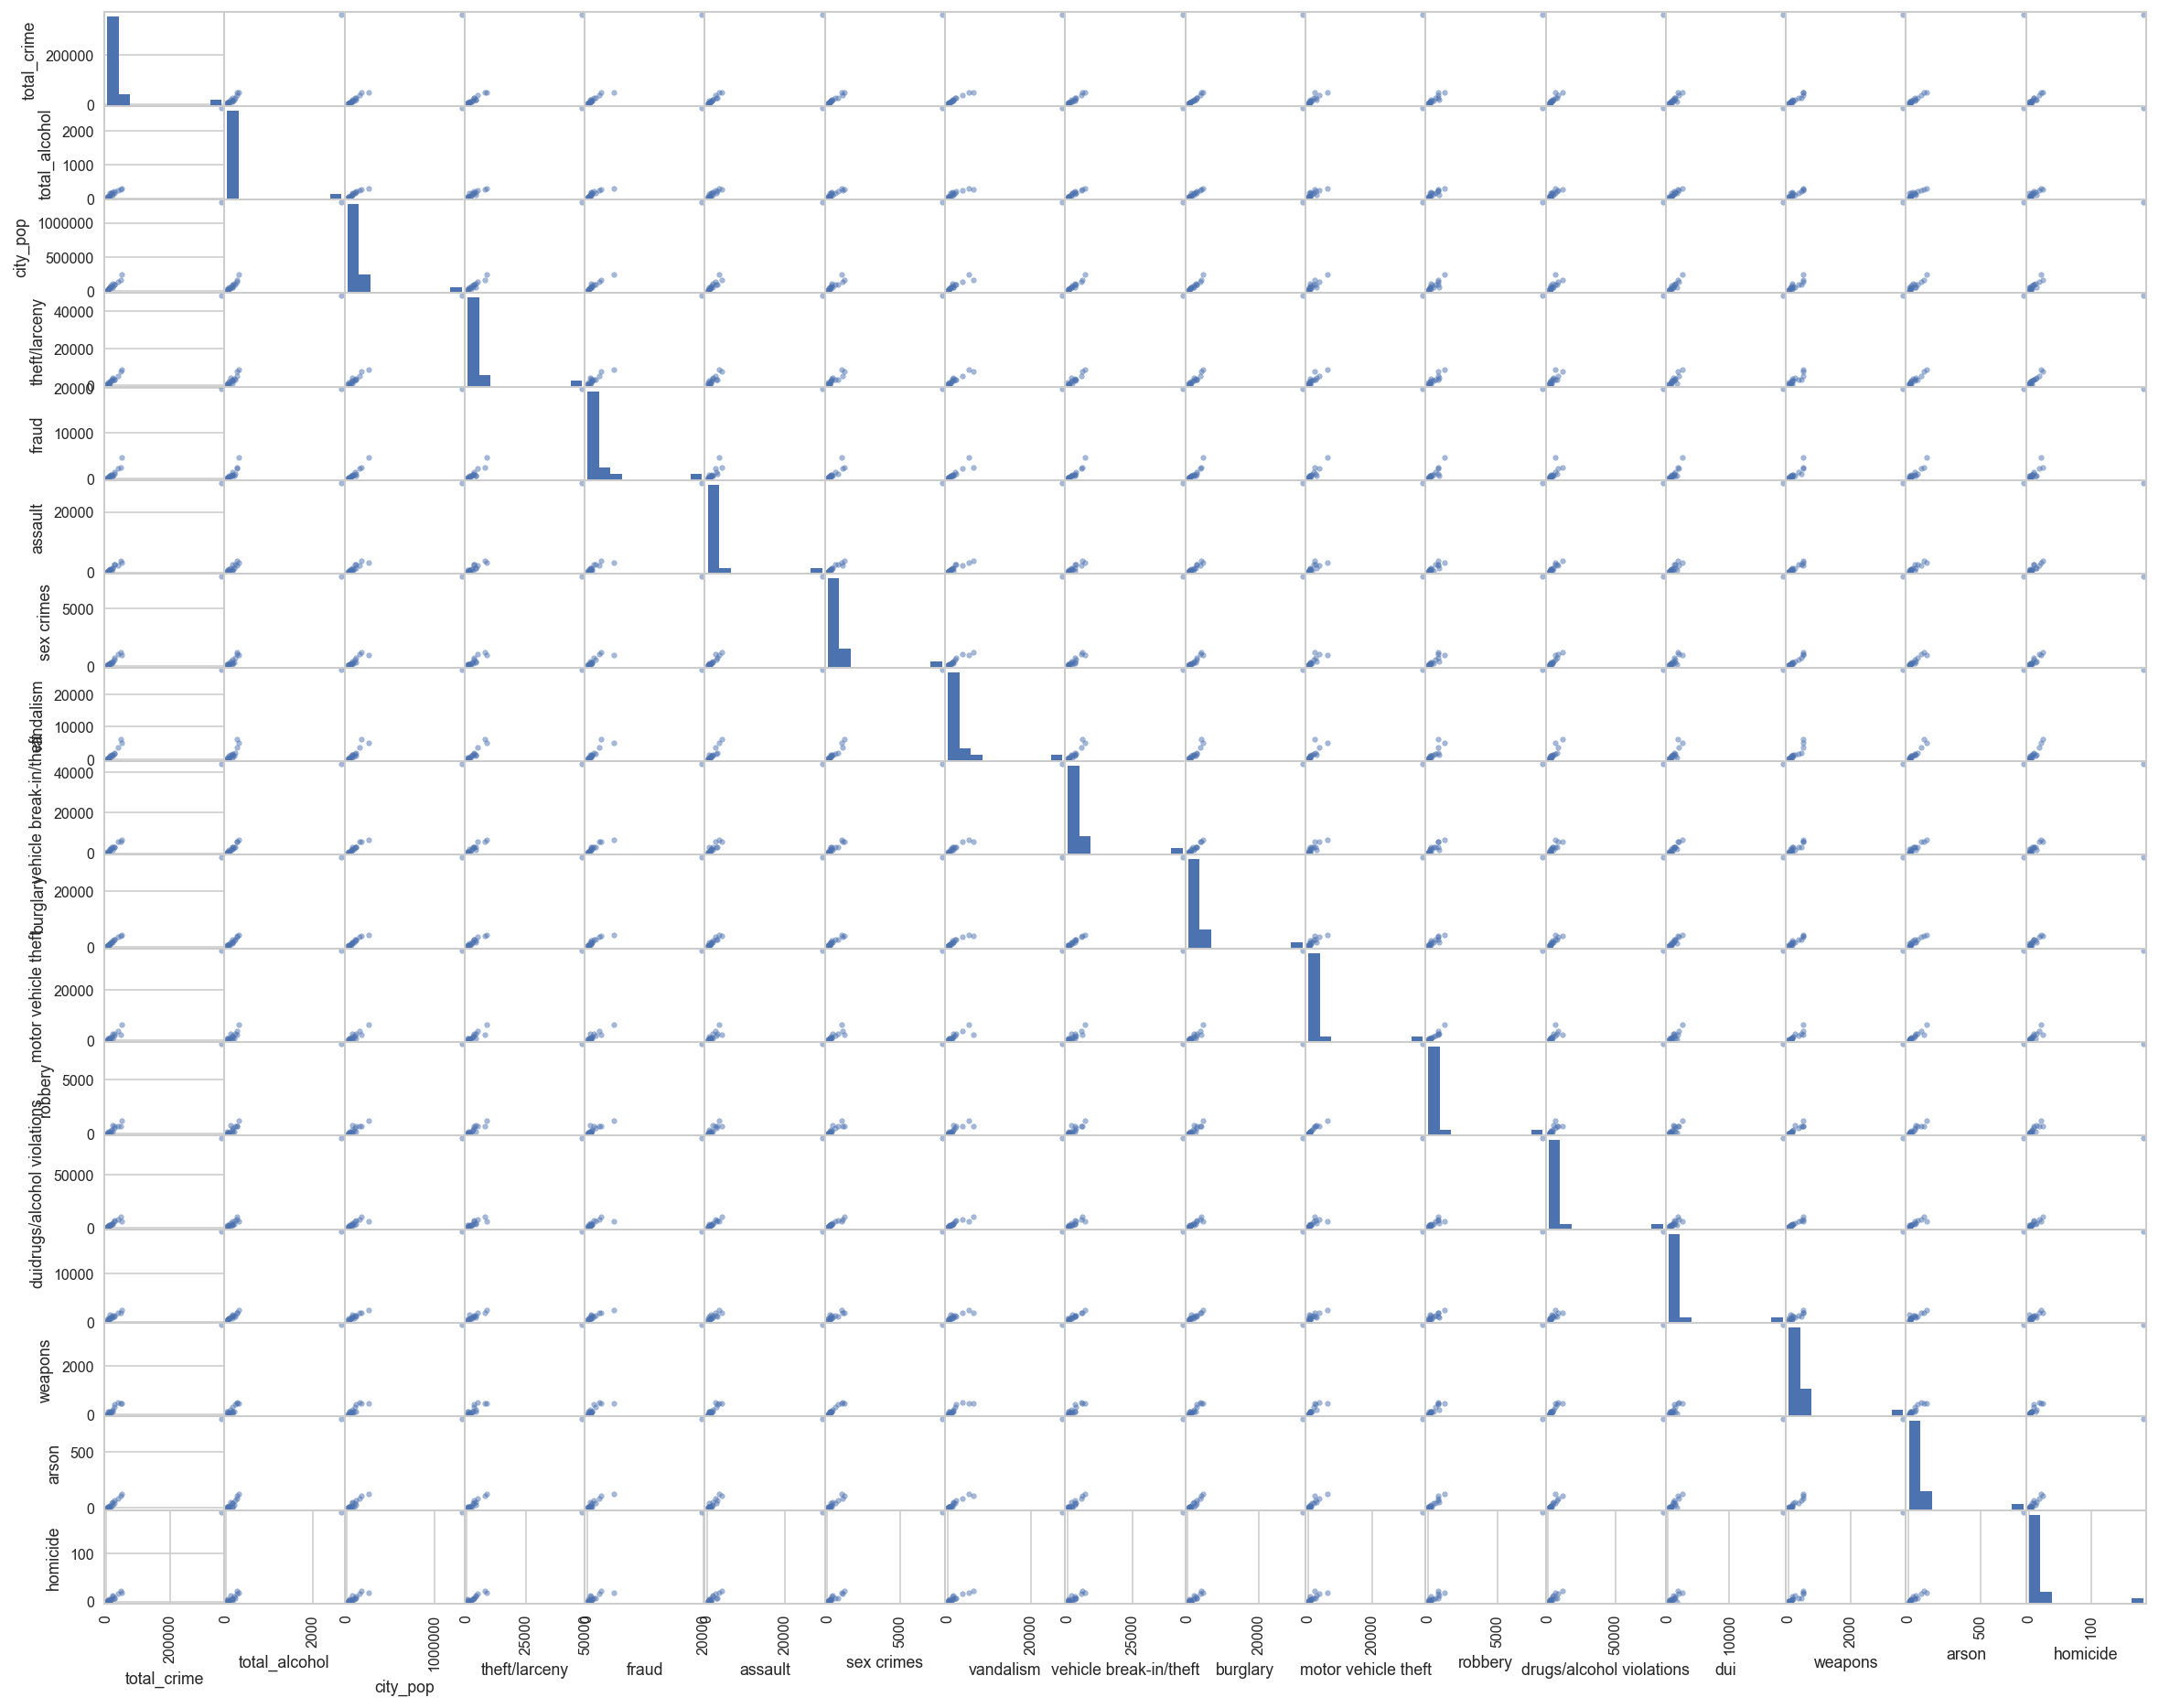

In [17]:
# an enormous scatter matrix of crimerates by type

fig = pd.scatter_matrix(aggregate_df, figsize=(20, 16))

In [18]:
# let's normalize that crime and alcohol data! 

aggregate_df['norm_crime'] = aggregate_df['total_crime'] / aggregate_df['city_pop']
aggregate_df['norm_alcohol'] = aggregate_df['total_alcohol'] / aggregate_df['city_pop']

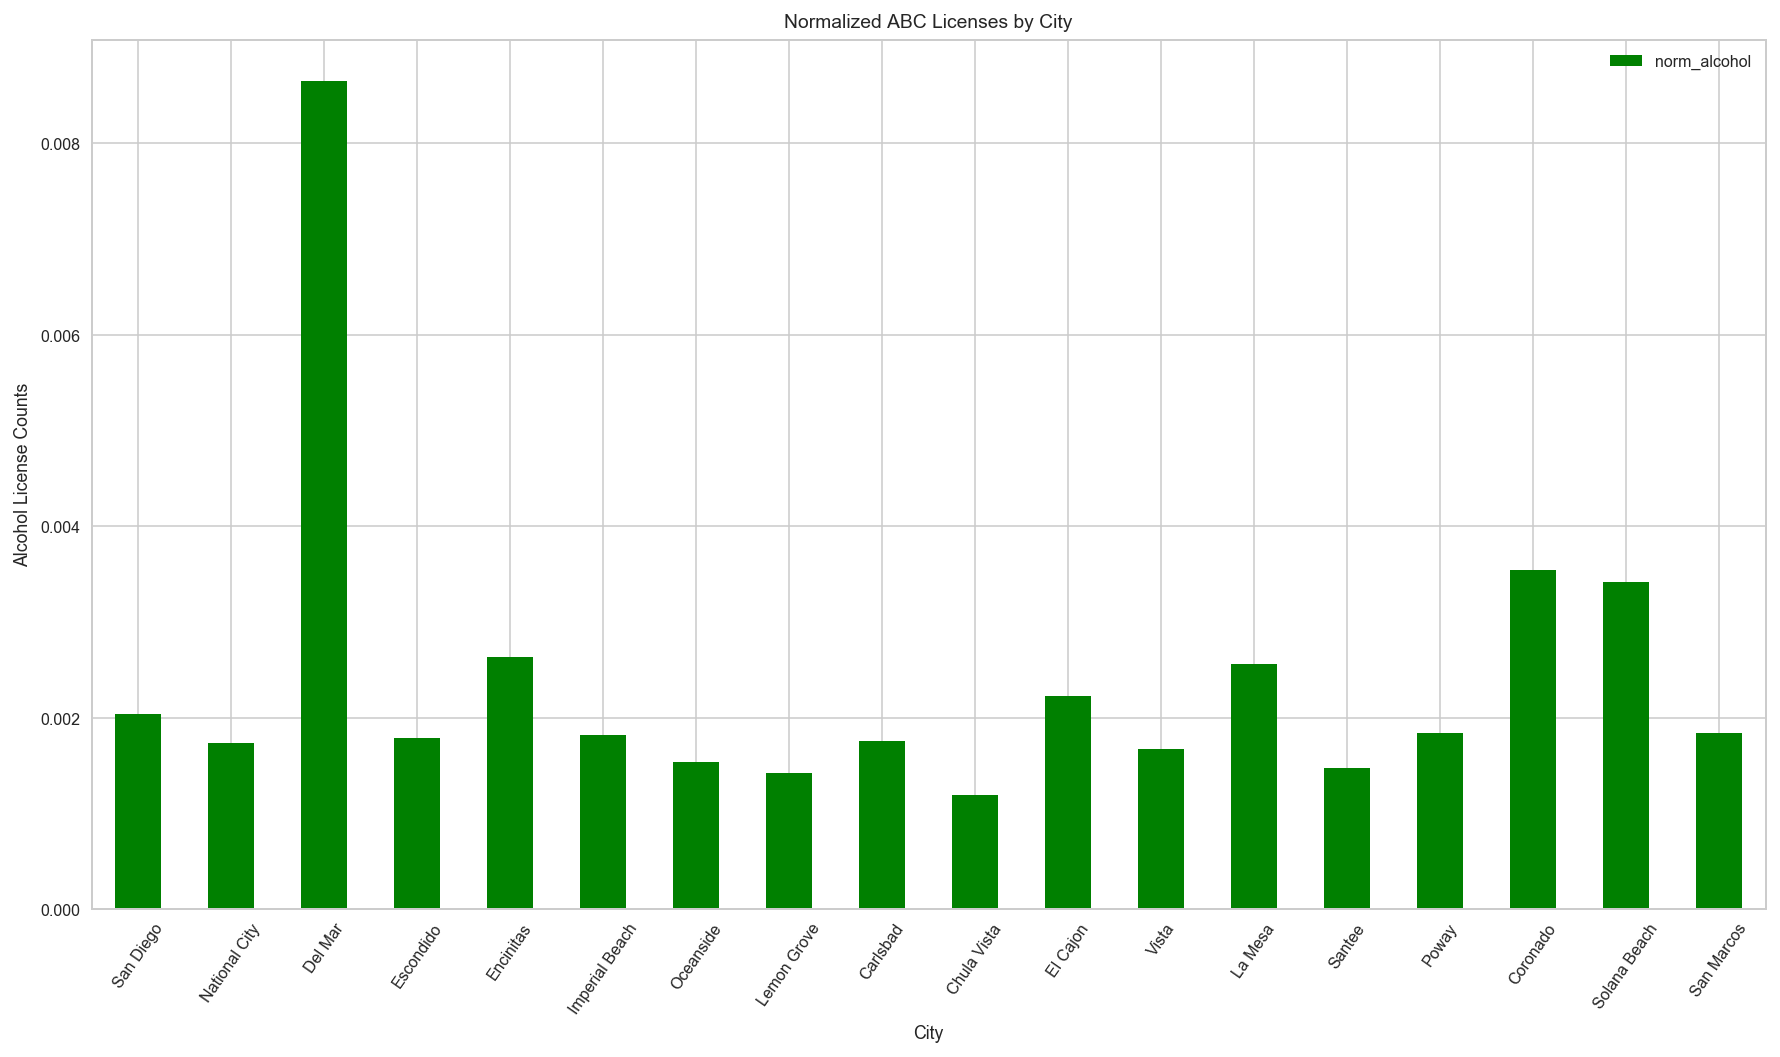

In [19]:
# a barplot of the normalized (by population) number of ABC licenses by city

axes = aggregate_df[['city_name', 'norm_alcohol']].plot.bar(figsize=(15,8), color="green")
axes.set_xticklabels(labels=aggregate_df.city_name, rotation=55)
axes.set(xlabel="City", ylabel="Alcohol License Counts", title="Normalized ABC Licenses by City")

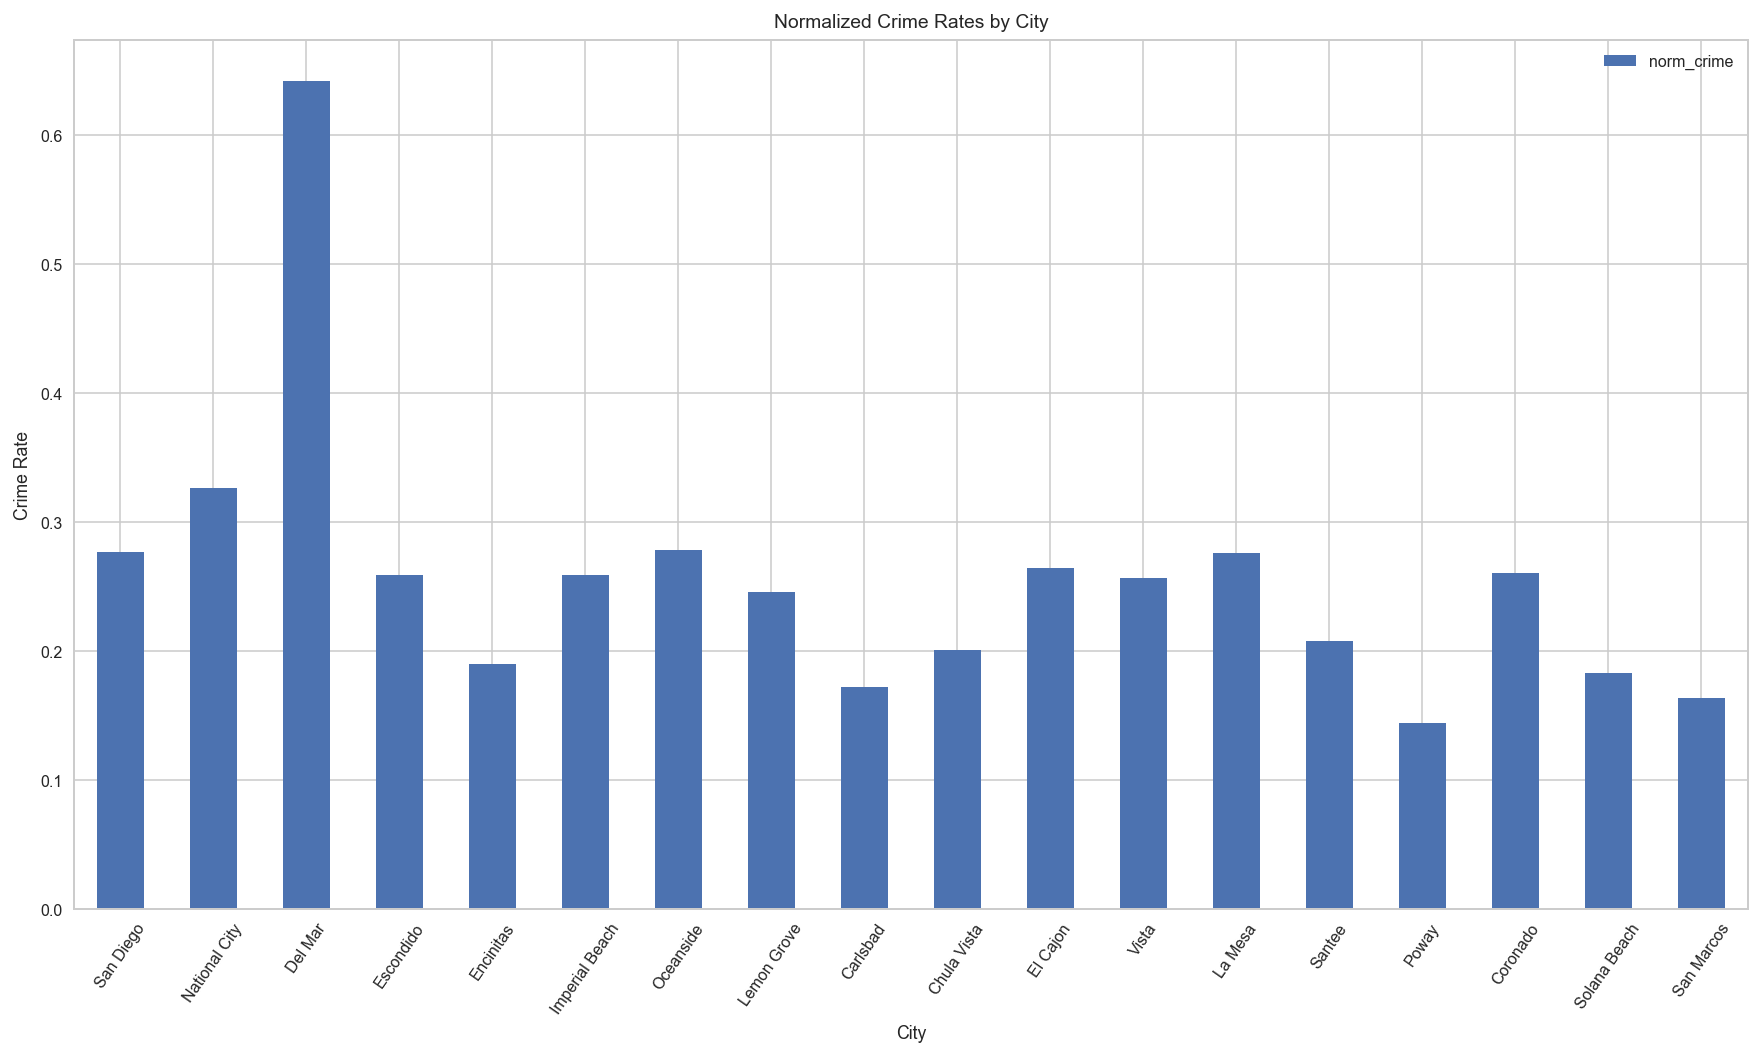

In [20]:
# a barplot of the per capita crime rate against city population by city

axes = aggregate_df[['city_name', 'norm_crime']].plot.bar(figsize=(15,8))
axes.set_xticklabels(labels=aggregate_df.city_name, rotation=55)
axes.set(xlabel="City", ylabel="Crime Rate", title="Normalized Crime Rates by City")

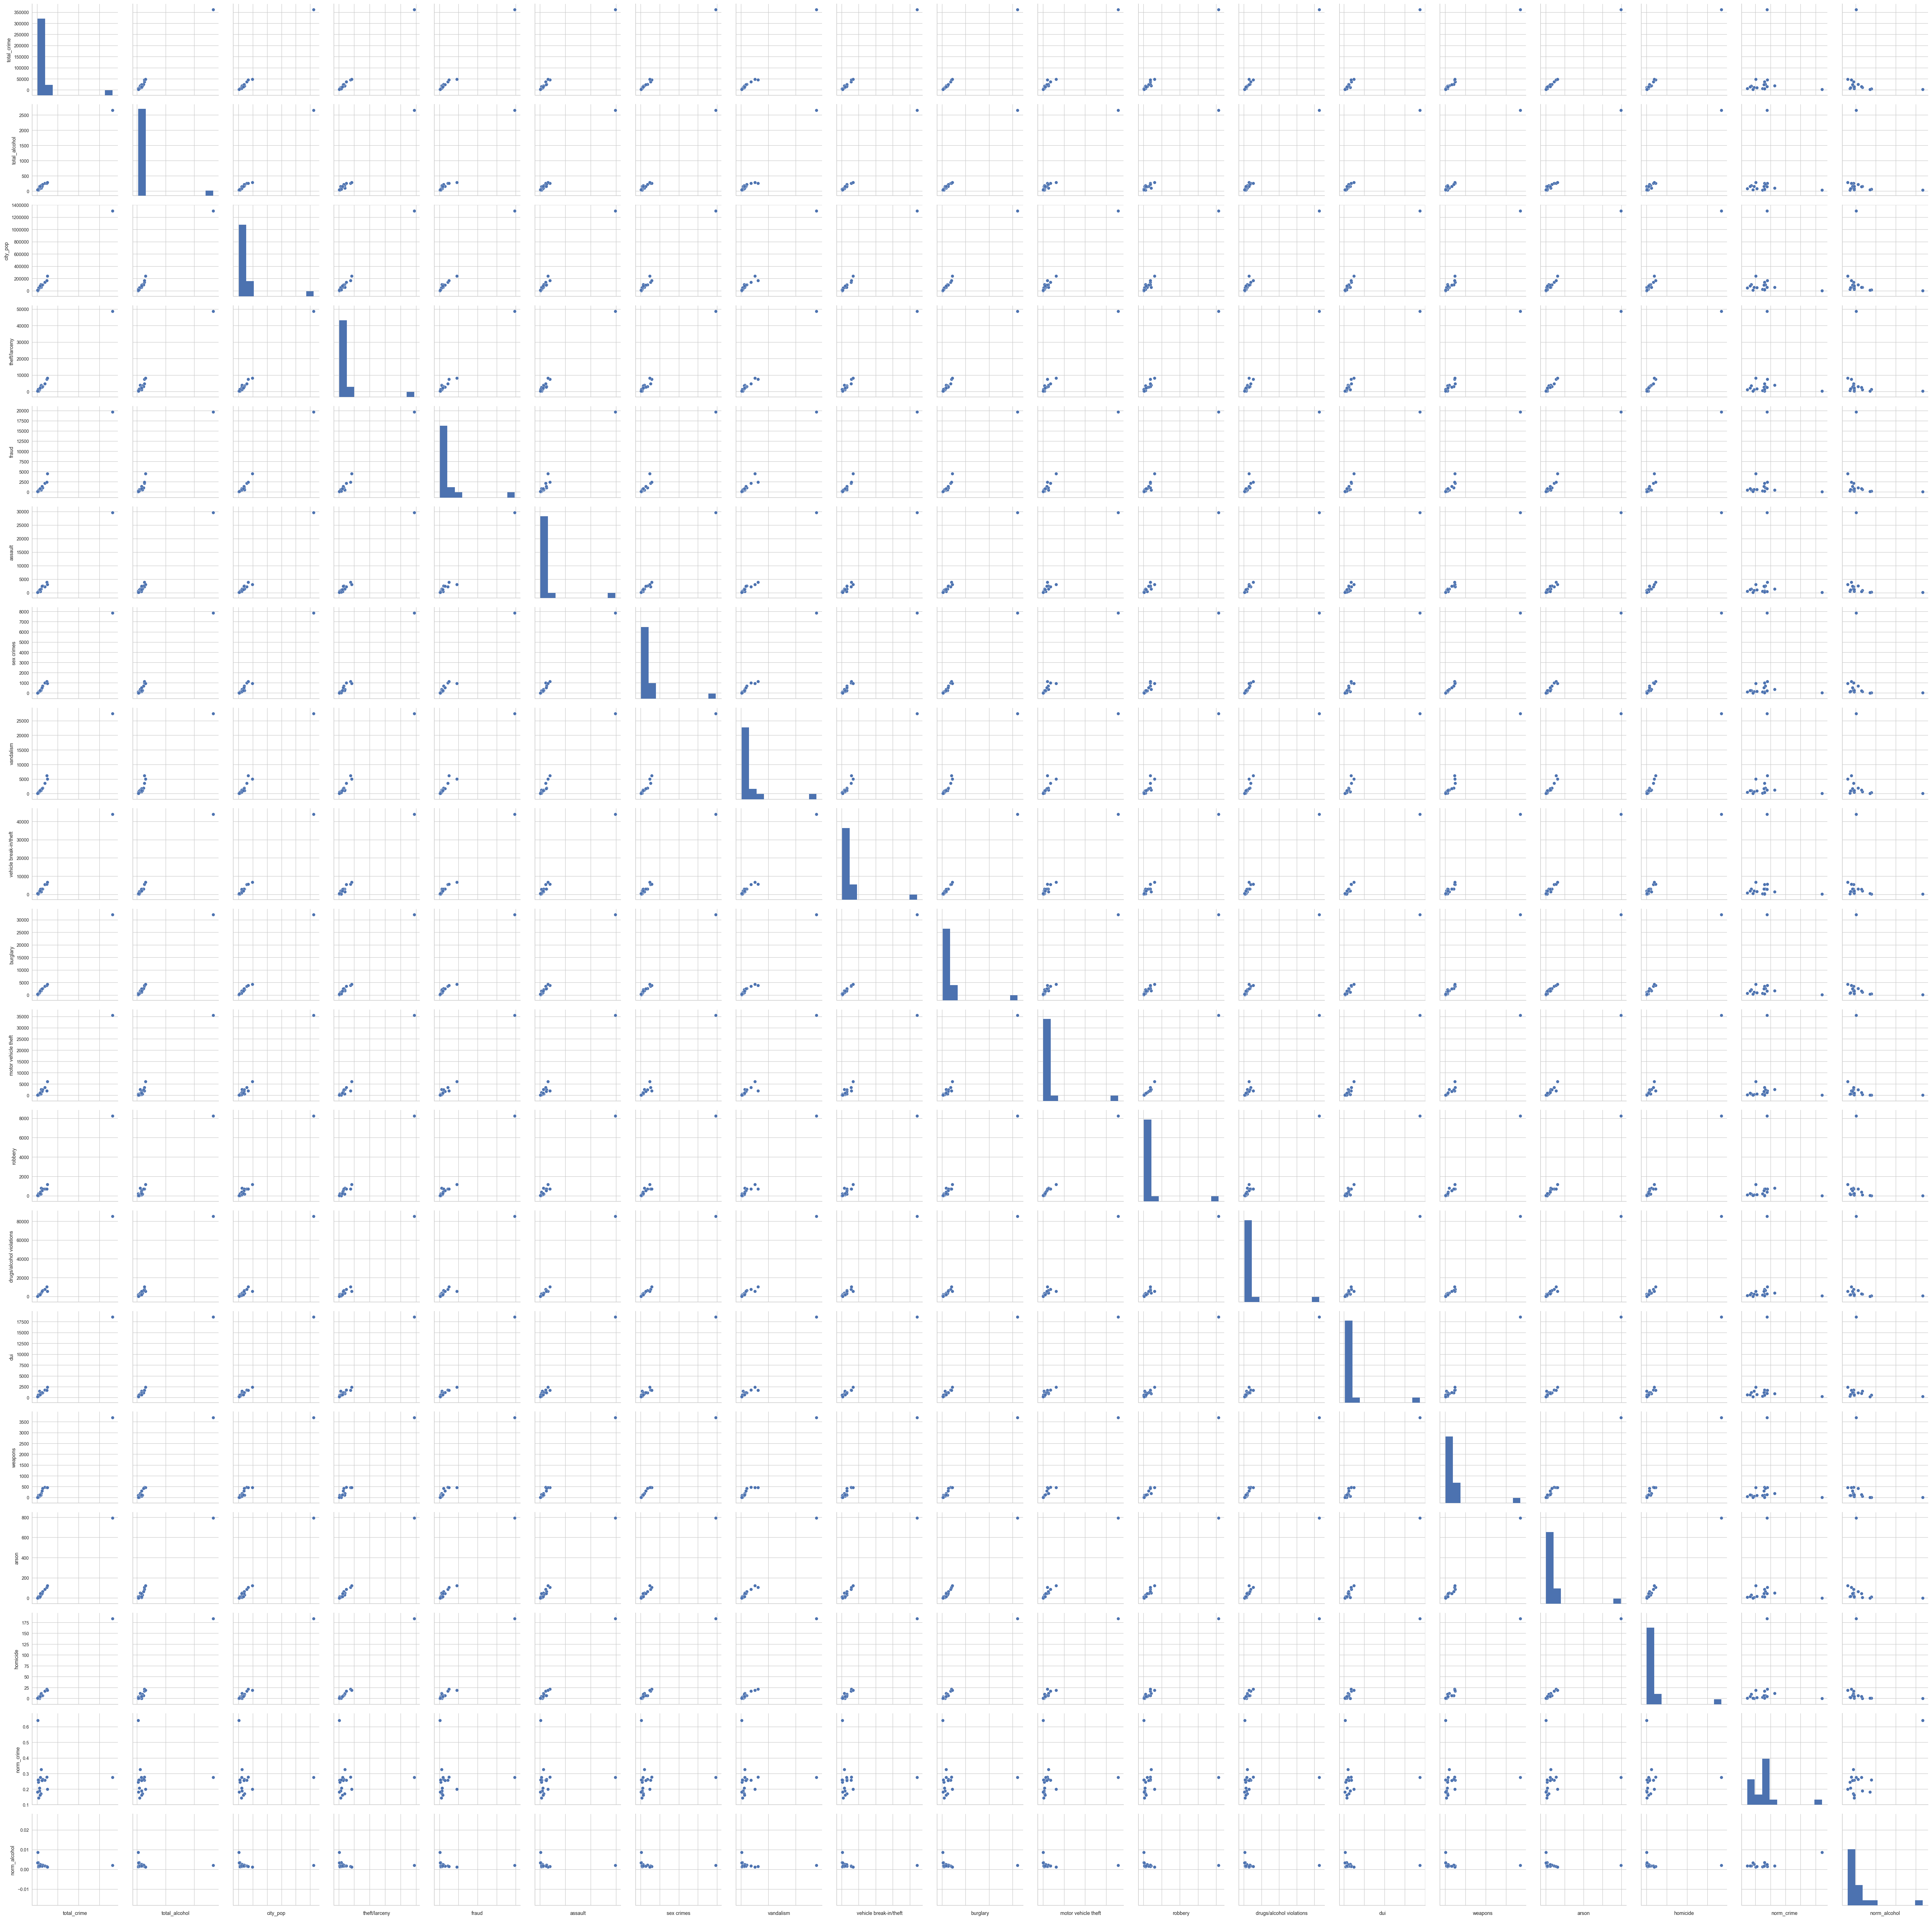

In [21]:
# an enormous collection of pairplots: population to number of crime incidents

dims = (30,30)
pairplots = sns.pairplot(aggregate_df)
pairplots.set(xticklabels=[])

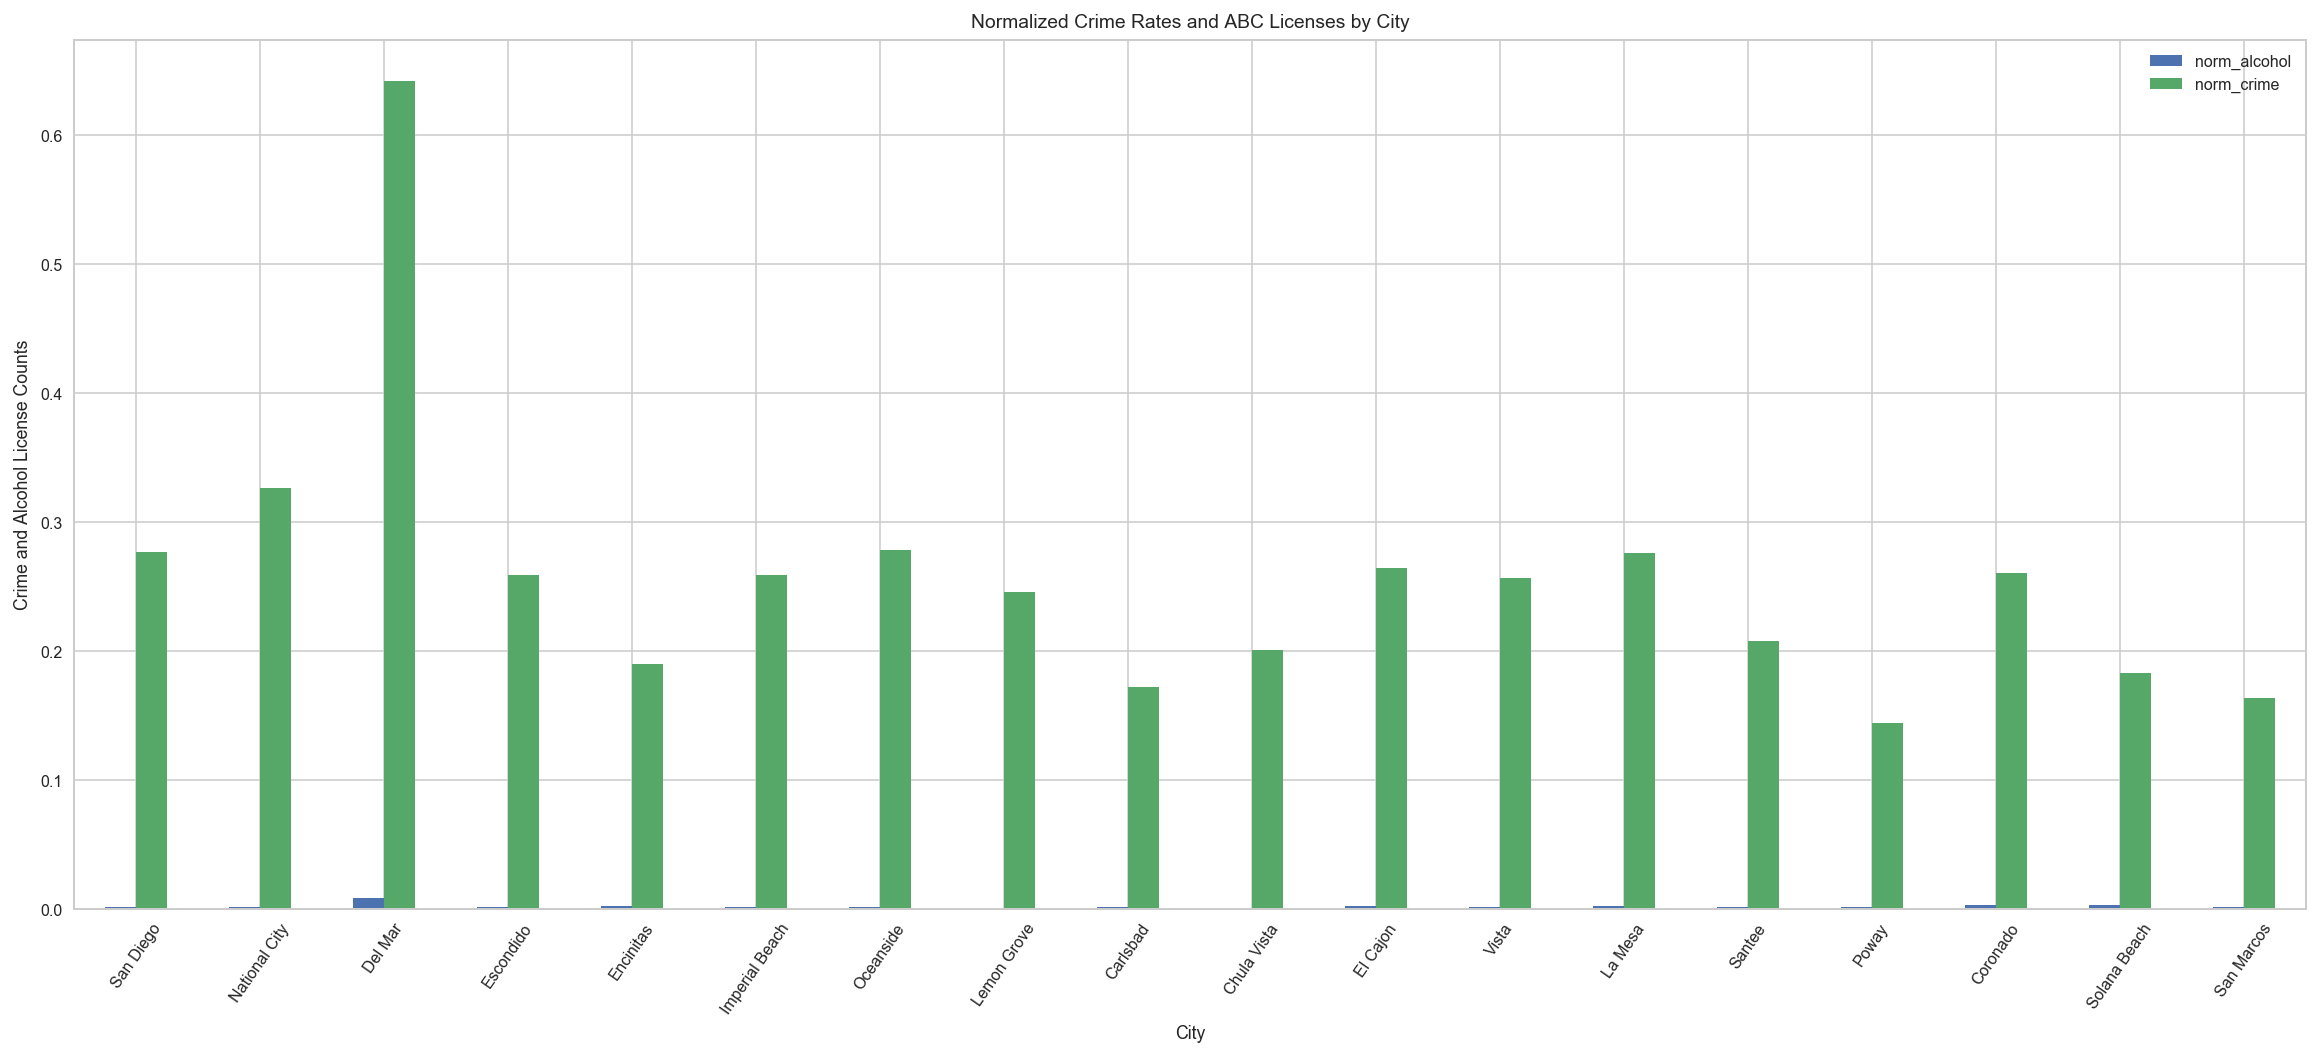

In [22]:
# yet another exciting barplot! normalized crime rates & ABC permits by city

axes = aggregate_df[['city_name', 'norm_alcohol', 'norm_crime']].plot.bar(figsize=(20,8))
axes.set_xticklabels(labels=aggregate_df.city_name, rotation=55)
axes.set(xlabel="City", ylabel="Crime and Alcohol License Counts", title="Normalized Crime Rates and ABC Licenses by City")

In [23]:
# let's see how the number of alcohol permits affect the rate of crime in a city! correlation table (normalized data)

x = aggregate_df['norm_alcohol']
y = aggregate_df['norm_crime']
aggregate_df.corr()

,total_crime,total_alcohol,city_pop,theft/larceny,fraud,assault,sex crimes,vandalism,vehicle break-in/theft,burglary,motor vehicle theft,robbery,drugs/alcohol violations,dui,weapons,arson,homicide,norm_crime,norm_alcohol
total_crime,1.000000,0.997659,0.997938,0.998015,0.994085,0.998399,0.998656,0.993670,0.998805,0.999584,0.995660,0.996861,0.997329,0.997195,0.997730,0.998834,0.998286,0.026363,-0.127323
total_alcohol,0.997659,1.000000,0.995728,0.993809,0.989016,0.996913,0.995099,0.985804,0.997054,0.998318,0.993013,0.993846,0.997079,0.998554,0.994404,0.994332,0.995782,0.014295,-0.110026
city_pop,0.997938,0.995728,1.000000,0.997633,0.997135,0.995151,0.995299,0.992816,0.998552,0.998080,0.994993,0.993966,0.991594,0.995602,0.994260,0.996589,0.994841,-0.006192,-0.149259
theft/larceny,0.998015,0.993809,0.997633,1.000000,0.994390,0.994879,0.995604,0.995012,0.997028,0.997306,0.993854,0.995110,0.992399,0.993871,0.993425,0.998088,0.997077,0.020010,-0.139655
fraud,0.994085,0.989016,0.997135,0.994390,1.000000,0.989168,0.991413,0.992535,0.995242,0.993042,0.994316,0.991072,0.984376,0.990744,0.990656,0.994610,0.989280,0.005806,-0.142906
assault,0.998399,0.996913,0.995151,0.994879,0.989168,1.000000,0.997443,0.990300,0.995709,0.998128,0.991858,0.994710,0.998503,0.995565,0.996889,0.995634,0.996684,0.026286,-0.125092
sex crimes,0.998656,0.995099,0.995299,0.995604,0.991413,0.997443,1.000000,0.994843,0.997174,0.998161,0.992821,0.994929,0.996993,0.993383,0.999044,0.998060,0.996725,0.036123,-0.128457
vandalism,0.993670,0.985804,0.992816,0.995012,0.992535,0.990300,0.994843,1.000000,0.993537,0.991810,0.985343,0.986845,0.987502,0.985449,0.991327,0.994895,0.990908,0.023355,-0.151182
vehicle break-in/theft,0.998805,0.997054,0.998552,0.997028,0.995242,0.995709,0.997174,0.993537,1.000000,0.998974,0.993978,0.993945,0.994525,0.996522,0.995785,0.997479,0.996007,0.012891,-0.132264
burglary,0.999584,0.998318,0.998080,0.997306,0.993042,0.998128,0.998161,0.991810,0.998974,1.000000,0.995052,0.996402,0.997061,0.997075,0.997548,0.997913,0.997746,0.016335,-0.132788


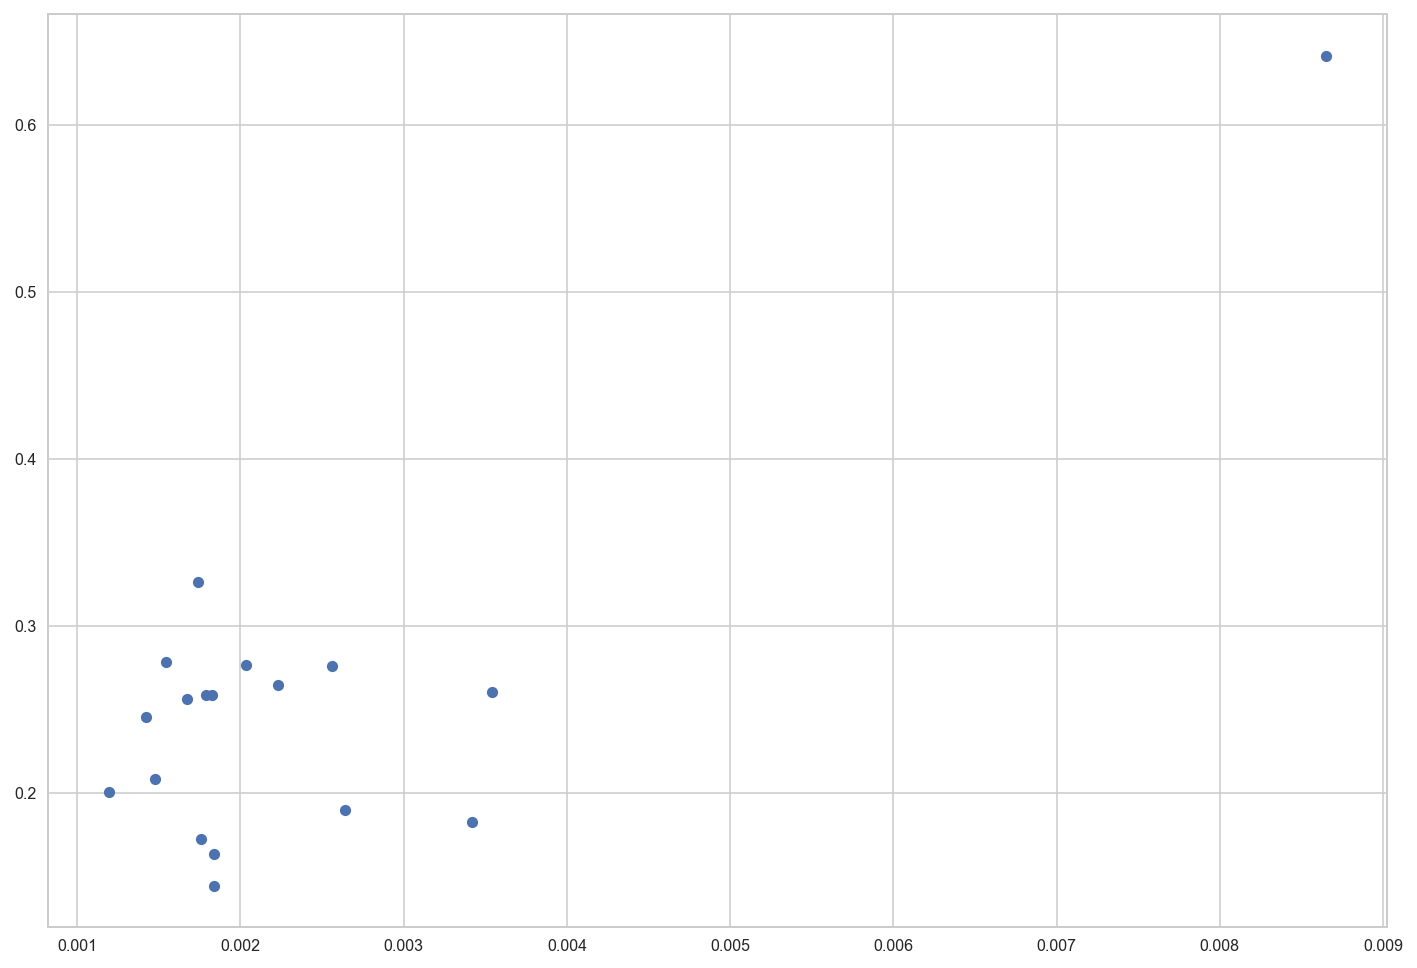

In [24]:
# check out the normalized alcohol license counts & normalized crime rates - each point represents a single city

plt.figure(figsize=(12,8.4))
plt.plot(x, y, "o")

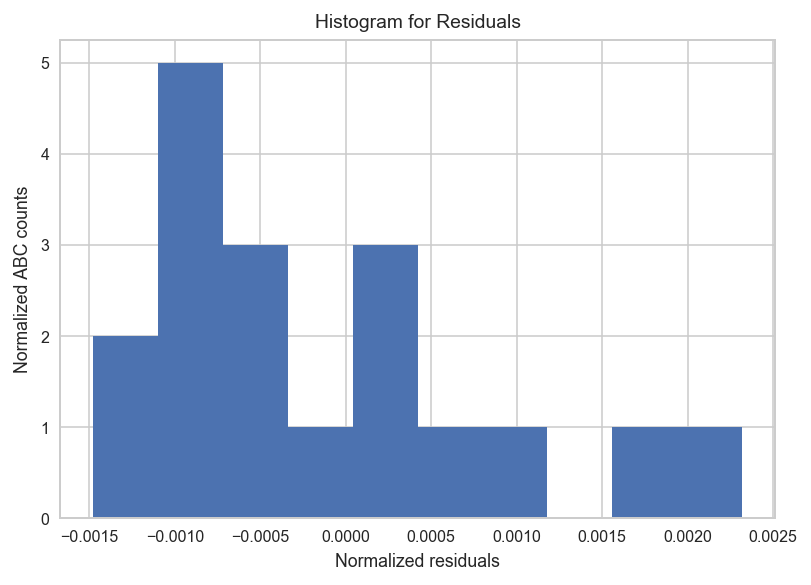

In [25]:
# compute correlation and linear regression model WITH DATA AS GIVEN (includes an outlier - can you tell which one?)

# checking the distribution/normality of the residuals
model = sm.OLS(x, y)
fit_to_get_residuals = model.fit()

# histogram of the normalized residuals: how's our distribution?
plt.hist(fit_to_get_residuals.resid)
plt.ylabel('Normalized ABC counts')
plt.xlabel('Normalized residuals')
plt.title('Histogram for Residuals')

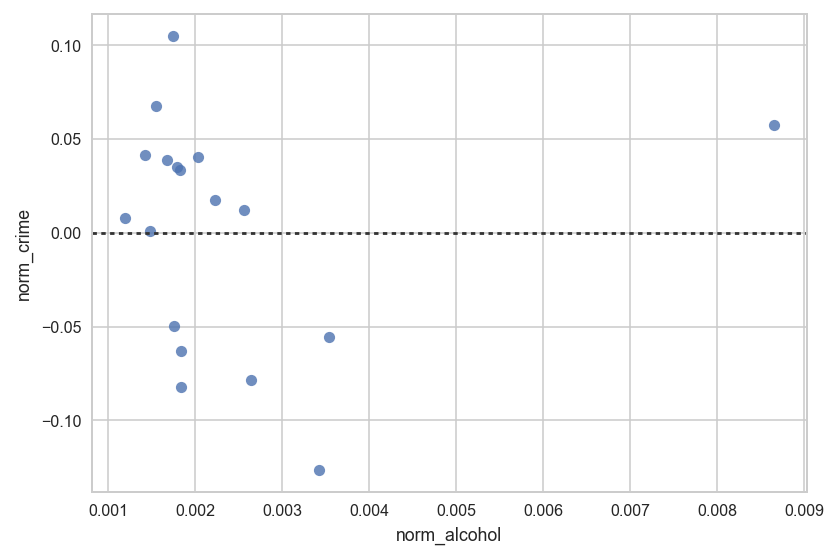

In [26]:
# we would like to grow up to be good [statisticians/researchers/data scientists/less clueless folks]:
# check out the plot of our residuals in a different form

sns.residplot(x, y)

slope: 52.502966021462662 | intercept: 0.12994011114197218 | correlation coefficient: 0.81999013989577585  | p_value: 3.0980689958183493e-05 | standard error: 9.1621602125046557


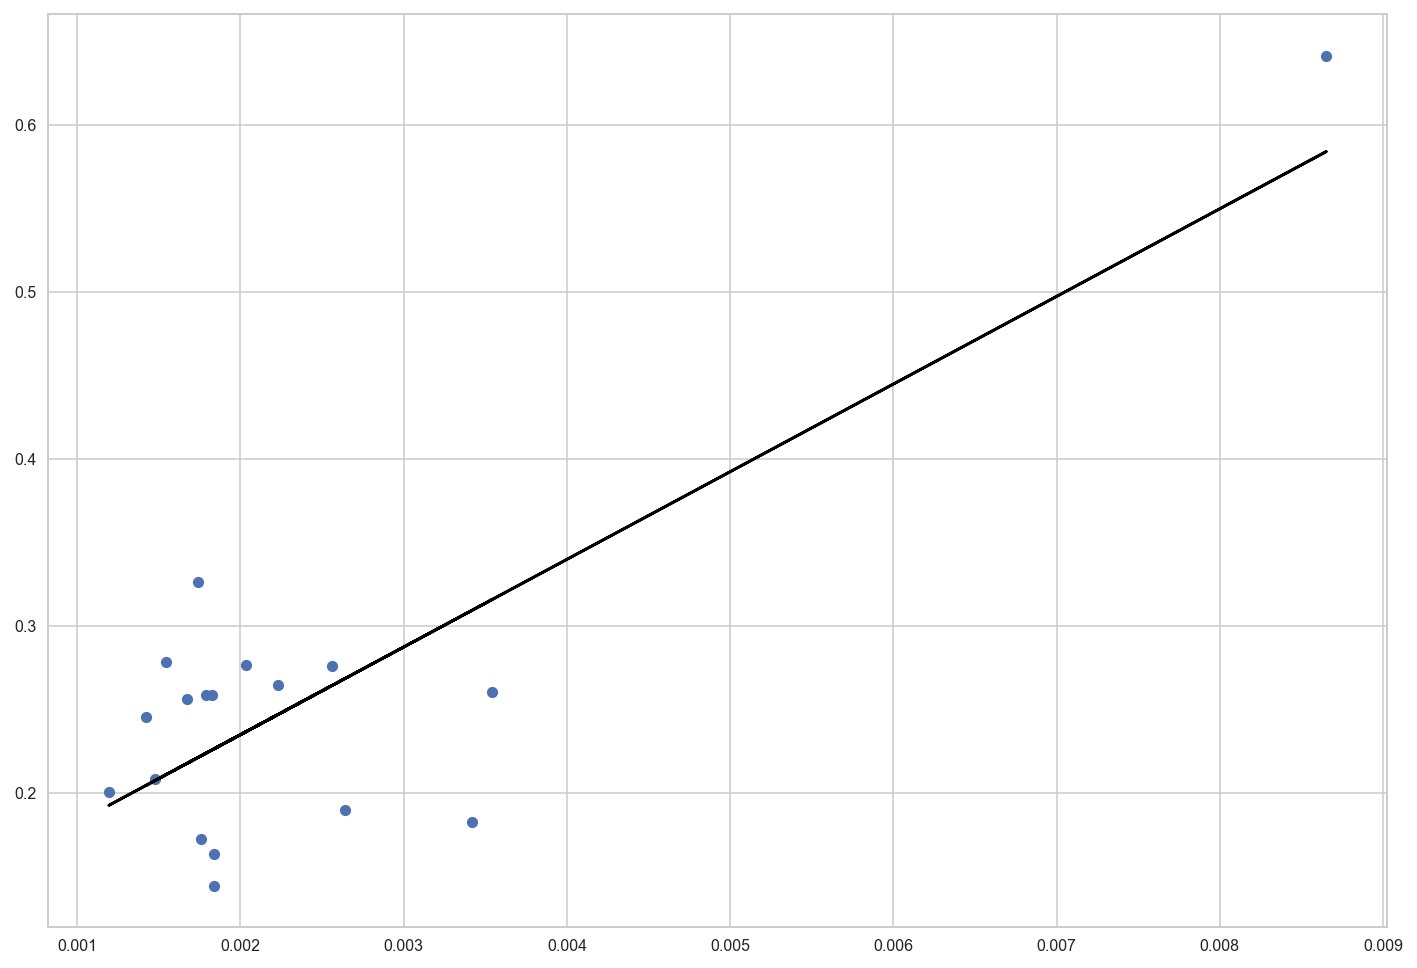

In [27]:
# fit the linear regression for crime to community population (still got a peculiar data point in the mix)

slope, intercept, corr_value, p_value, std_err = stats.linregress(x,y)

predicted_y = intercept + slope * x
predicted_error = y - predicted_y
degr_freedom = len(x) - 2
residual_std_error = np.sqrt(np.sum(predicted_error ** 2) / degr_freedom)

# display the slope, intercept, correlation coefficient, p value, and standard error
display = "slope: " + repr(slope) + " | intercept: " + repr(intercept) + " | correlation coefficient: " + repr(corr_value)
display2 = " | p_value: " + repr(p_value) + " | standard error: " + repr(std_err)
print(display, display2)

# plotting linear regression/least squares
plt.figure(figsize=(12,8.4))
plt.plot(x, y, 'o')
plt.plot(x, predicted_y, 'k-')
plt.show()

In [28]:
# now, let's repeat the process AFTER removing the outlier - pesky Del Mar...

sans_outlier = aggregate_df[aggregate_df['city_name'] != 'Del Mar']

# plot the normalized alcohol license counts & normalized crime rates
x2 = sans_outlier['norm_alcohol']
y2 = sans_outlier['norm_crime']

# the correlation matrix
sans_outlier.corr()

,total_crime,total_alcohol,city_pop,theft/larceny,fraud,assault,sex crimes,vandalism,vehicle break-in/theft,burglary,motor vehicle theft,robbery,drugs/alcohol violations,dui,weapons,arson,homicide,norm_crime,norm_alcohol
total_crime,1.000000,0.997640,0.998025,0.998022,0.994030,0.998385,0.998643,0.993659,0.998800,0.999601,0.995628,0.996827,0.997370,0.997168,0.997720,0.998829,0.998283,0.263443,-0.083197
total_alcohol,0.997640,1.000000,0.995847,0.993802,0.988930,0.996882,0.995050,0.985750,0.997051,0.998349,0.992944,0.993787,0.997084,0.998539,0.994384,0.994298,0.995742,0.229722,-0.045901
city_pop,0.998025,0.995847,1.000000,0.997628,0.997149,0.995245,0.995380,0.992722,0.998592,0.998090,0.995136,0.994005,0.991853,0.995701,0.994229,0.996606,0.994987,0.220927,-0.105121
theft/larceny,0.998022,0.993802,0.997628,1.000000,0.994325,0.994873,0.995597,0.994955,0.996999,0.997274,0.993867,0.995083,0.992506,0.993853,0.993347,0.998071,0.997131,0.264675,-0.097219
fraud,0.994030,0.988930,0.997149,0.994325,1.000000,0.989075,0.991339,0.992463,0.995186,0.992959,0.994304,0.990983,0.984353,0.990669,0.990544,0.994547,0.989217,0.227529,-0.112660
assault,0.998385,0.996882,0.995245,0.994873,0.989075,1.000000,0.997416,0.990283,0.995684,0.998148,0.991780,0.994657,0.998531,0.995520,0.996887,0.995607,0.996655,0.258268,-0.083387
sex crimes,0.998643,0.995050,0.995380,0.995597,0.991339,0.997416,1.000000,0.994869,0.997160,0.998174,0.992754,0.994876,0.997014,0.993314,0.999060,0.998054,0.996698,0.281761,-0.090251
vandalism,0.993659,0.985750,0.992722,0.994955,0.992463,0.990283,0.994869,1.000000,0.993482,0.991717,0.985312,0.986753,0.987632,0.985374,0.991234,0.994859,0.990946,0.279650,-0.118606
vehicle break-in/theft,0.998800,0.997051,0.998592,0.996999,0.995186,0.995684,0.997160,0.993482,1.000000,0.998965,0.993957,0.993886,0.994594,0.996505,0.995736,0.997449,0.996010,0.241859,-0.086168
burglary,0.999601,0.998349,0.998090,0.997274,0.992959,0.998148,0.998174,0.991717,0.998965,1.000000,0.995065,0.996382,0.997195,0.997082,0.997518,0.997892,0.997792,0.254120,-0.081938


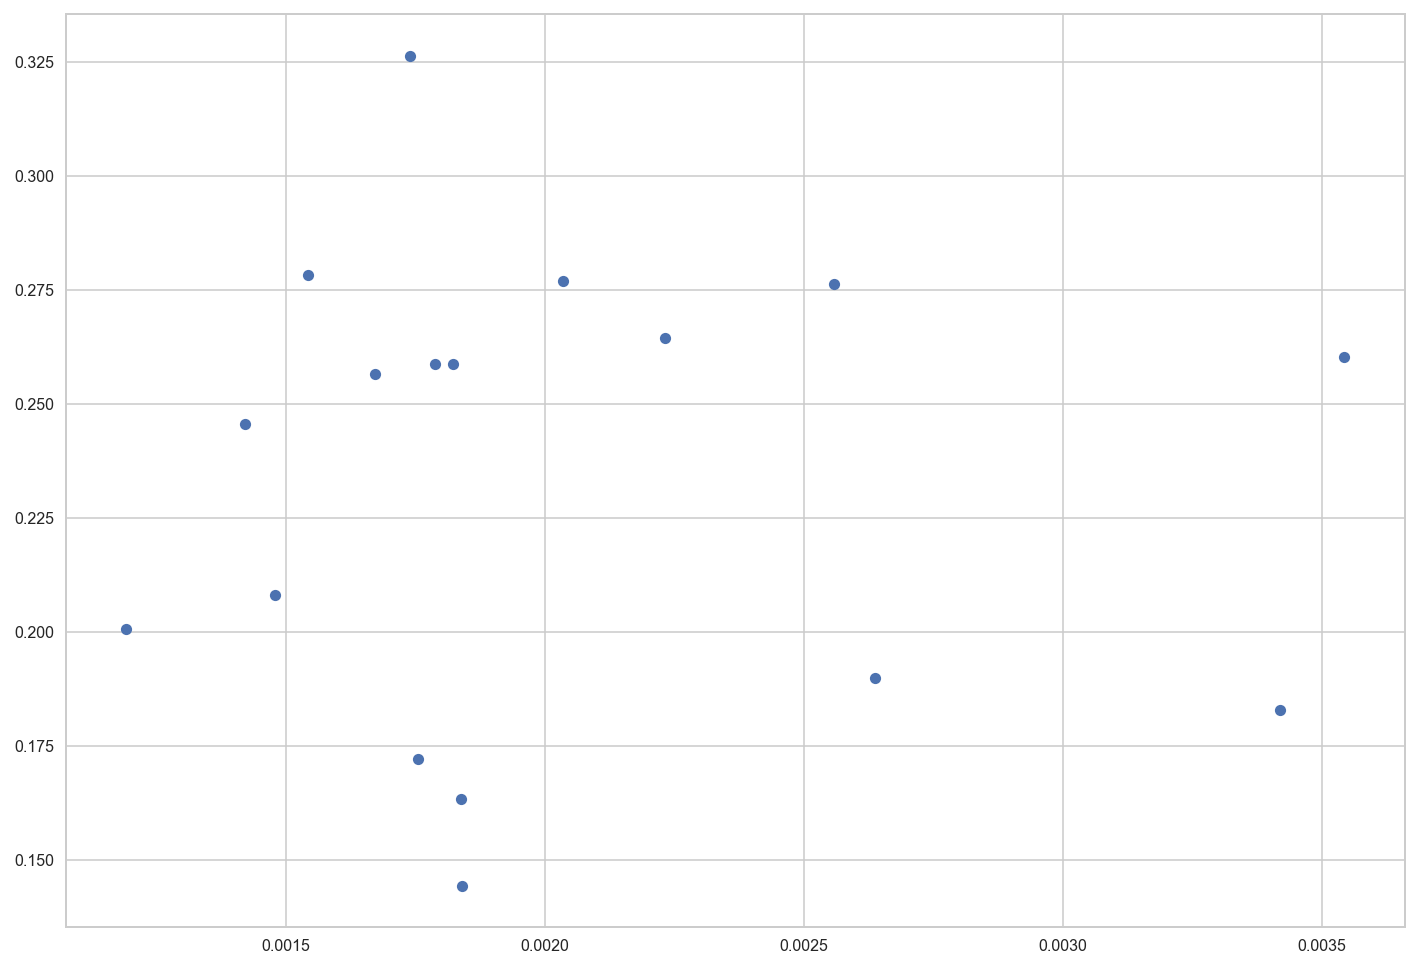

In [29]:
# check out the new plot of normalized alcohol license counts & normalized crime rates (points are cities)

plt.figure(figsize=(12,8.4))
plt.plot(x2, y2, "o")

slope: -2.0406404309321453 | intercept: 0.23732791191767363 | correlation coefficient: -0.02670488364458512  | p_value: 0.9189649900263408 | standard error: 19.723103486856616


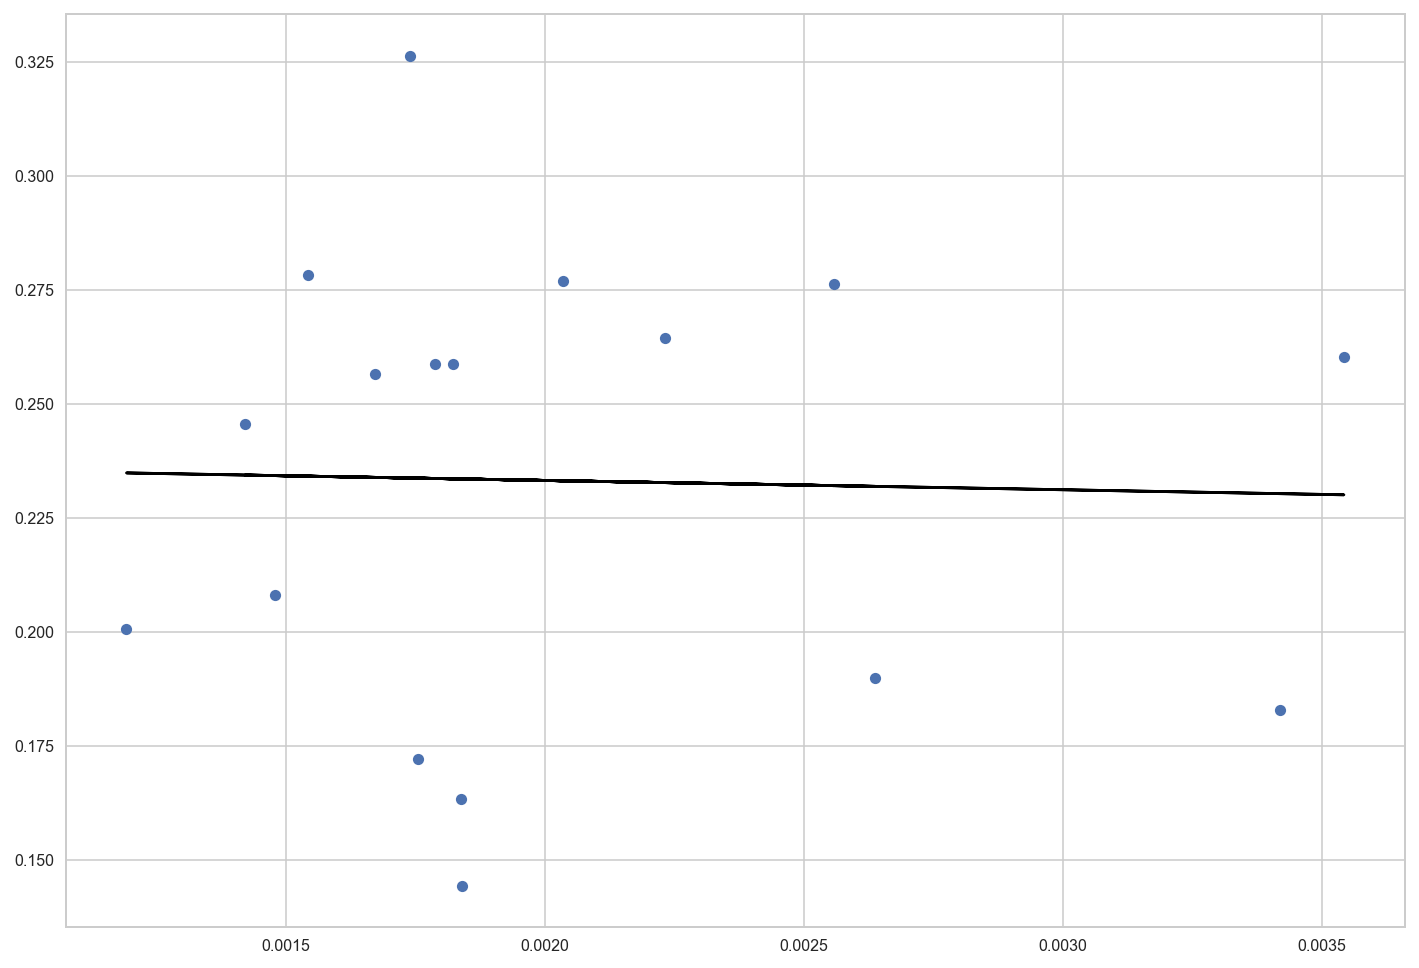

In [30]:
# hmmm, not as pretty as the last one! let's fit the linear regression without outlier anyway

slope2, intercept2, corr_value2, p_value2, std_err2 = stats.linregress(x2,y2)

predicted_y2 = intercept2 + slope2 * x2
predicted_error2 = y2 - predicted_y2
degr_freedom2 = len(x2) - 2
residual_std_error2 = np.sqrt(np.sum(predicted_error2 ** 2) / degr_freedom2)

display3 = "slope: " + repr(slope2) + " | intercept: " + repr(intercept2) + " | correlation coefficient: " + repr(corr_value2)
display4 = " | p_value: " + repr(p_value2) + " | standard error: " + repr(std_err2)
print(display3, display4)

# plotting linear regression/least squares 
plt.figure(figsize=(12,8.4))
plt.plot(x2, y2, 'o')
plt.plot(x2, predicted_y2, 'k-')
plt.show()

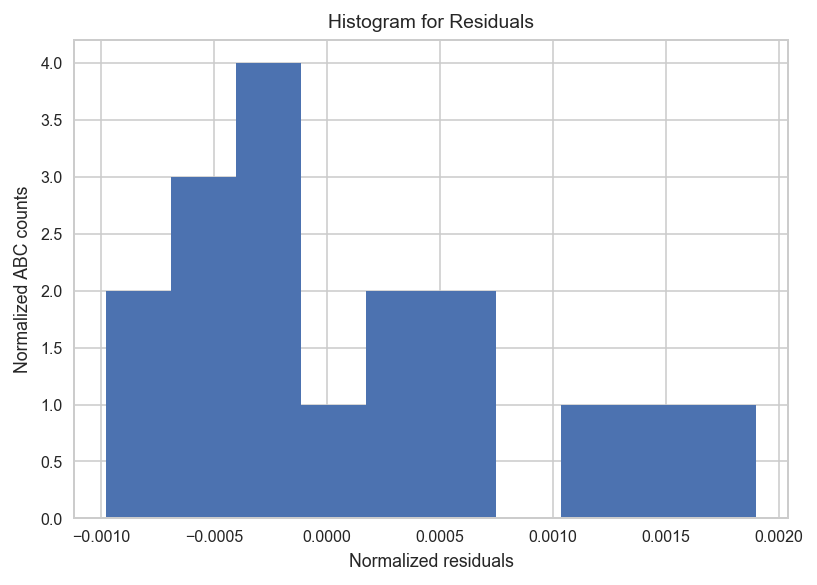

In [31]:
# computing Pearson correlation and linear regression model WITHOUT OUTLIER DATA POINT

# checking the distribution/normality of the residuals
model2 = sm.OLS(x2, y2)
fit_to_get_residuals2 = model2.fit()

# histogram of the normalized residuals: how's our distribution?
plt.hist(fit_to_get_residuals2.resid)
plt.ylabel('Normalized ABC counts')
plt.xlabel('Normalized residuals')
plt.title('Histogram for Residuals')

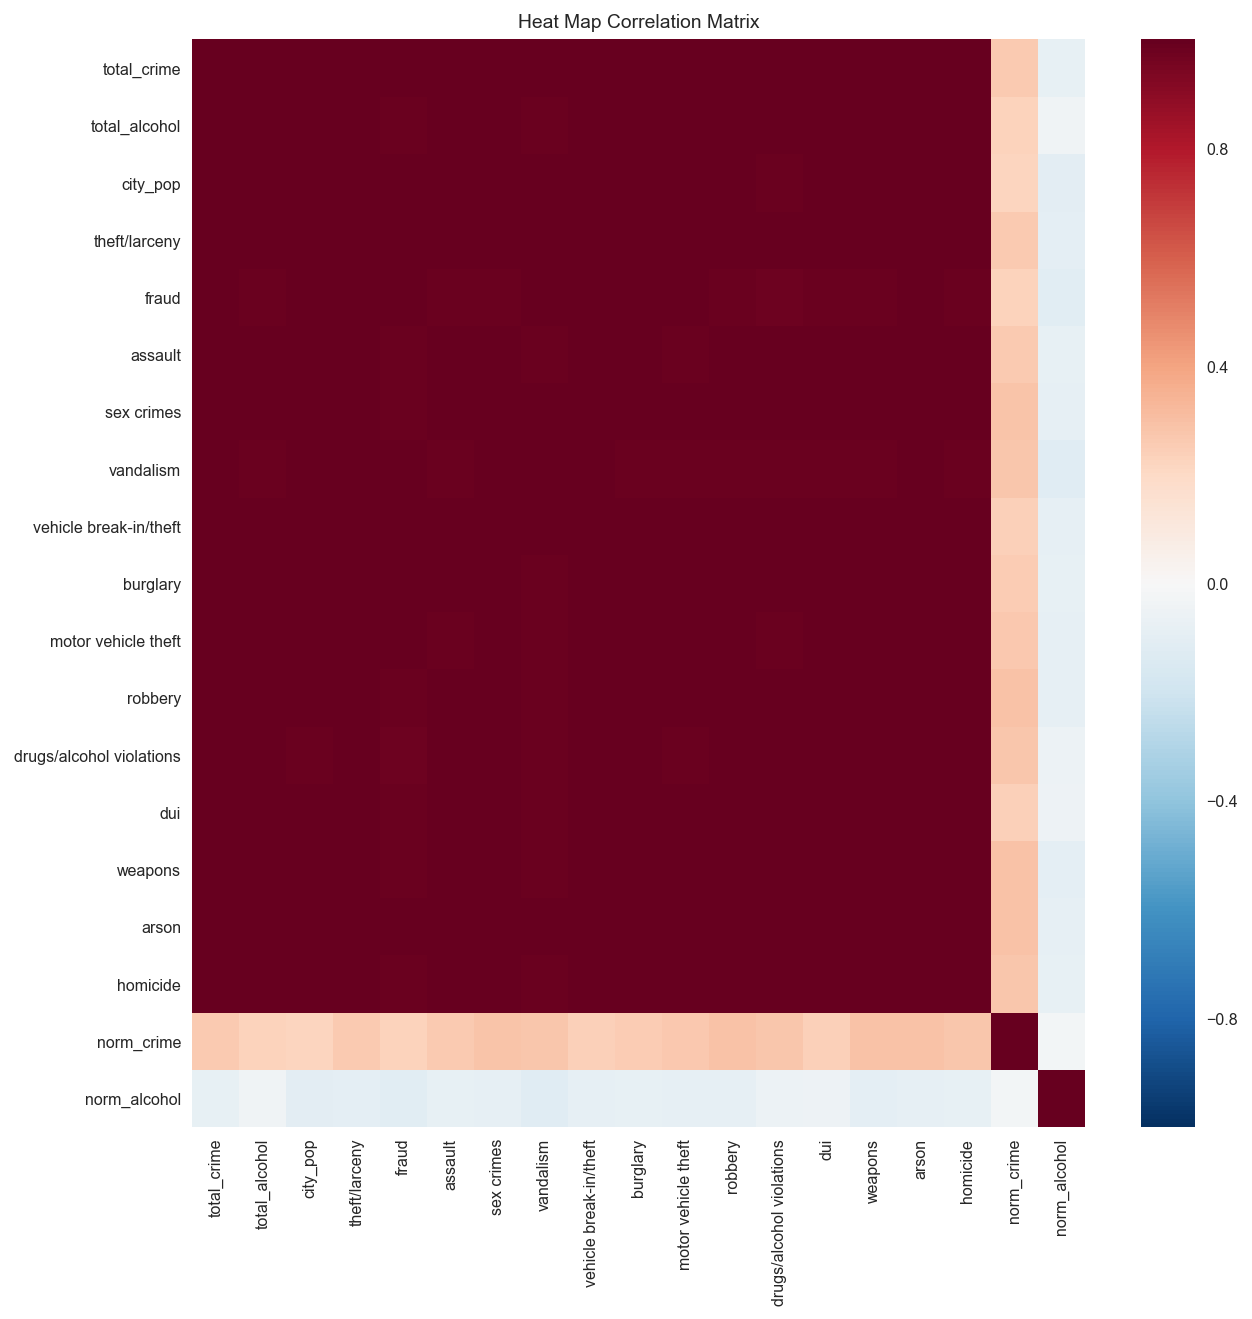

In [32]:
# correlation matrix (Pearson) of crime to population by community

plt.subplots(figsize=(10,10))
crime_corr = sans_outlier.corr()
crime_heatmap = sns.heatmap(crime_corr, 
            xticklabels=crime_corr.columns.values,
            yticklabels=crime_corr.columns.values)
crime_heatmap.set(title='Heat Map Correlation Matrix')

Looks like crime correlates to crime (hmmm, more crime means more crime?).
What about those two light columns along the right and bottom? That's our normalized crime and alcohol data!!

In [33]:
# let's look at violent crimes: assault, robbery, weapons, sex crimes, arson, homicide

violent_df = sans_outlier.loc[:, ['city_name', 'city_pop', 'norm_alcohol', 'assault', 'robbery', 'weapons', 'sex crimes', 'arson', 'homicide']]
# print(violent_df)

# normalize all crime and multiply by a factor of 100 to maintain precision 

col_names = list()
col_names = ('assault', 'robbery', 'weapons', 'sex crimes', 'arson', 'homicide')
for name in col_names:
    violent_df.loc[:, name] = (violent_df[name] / violent_df['city_pop']) * 100
# print(violent_df)

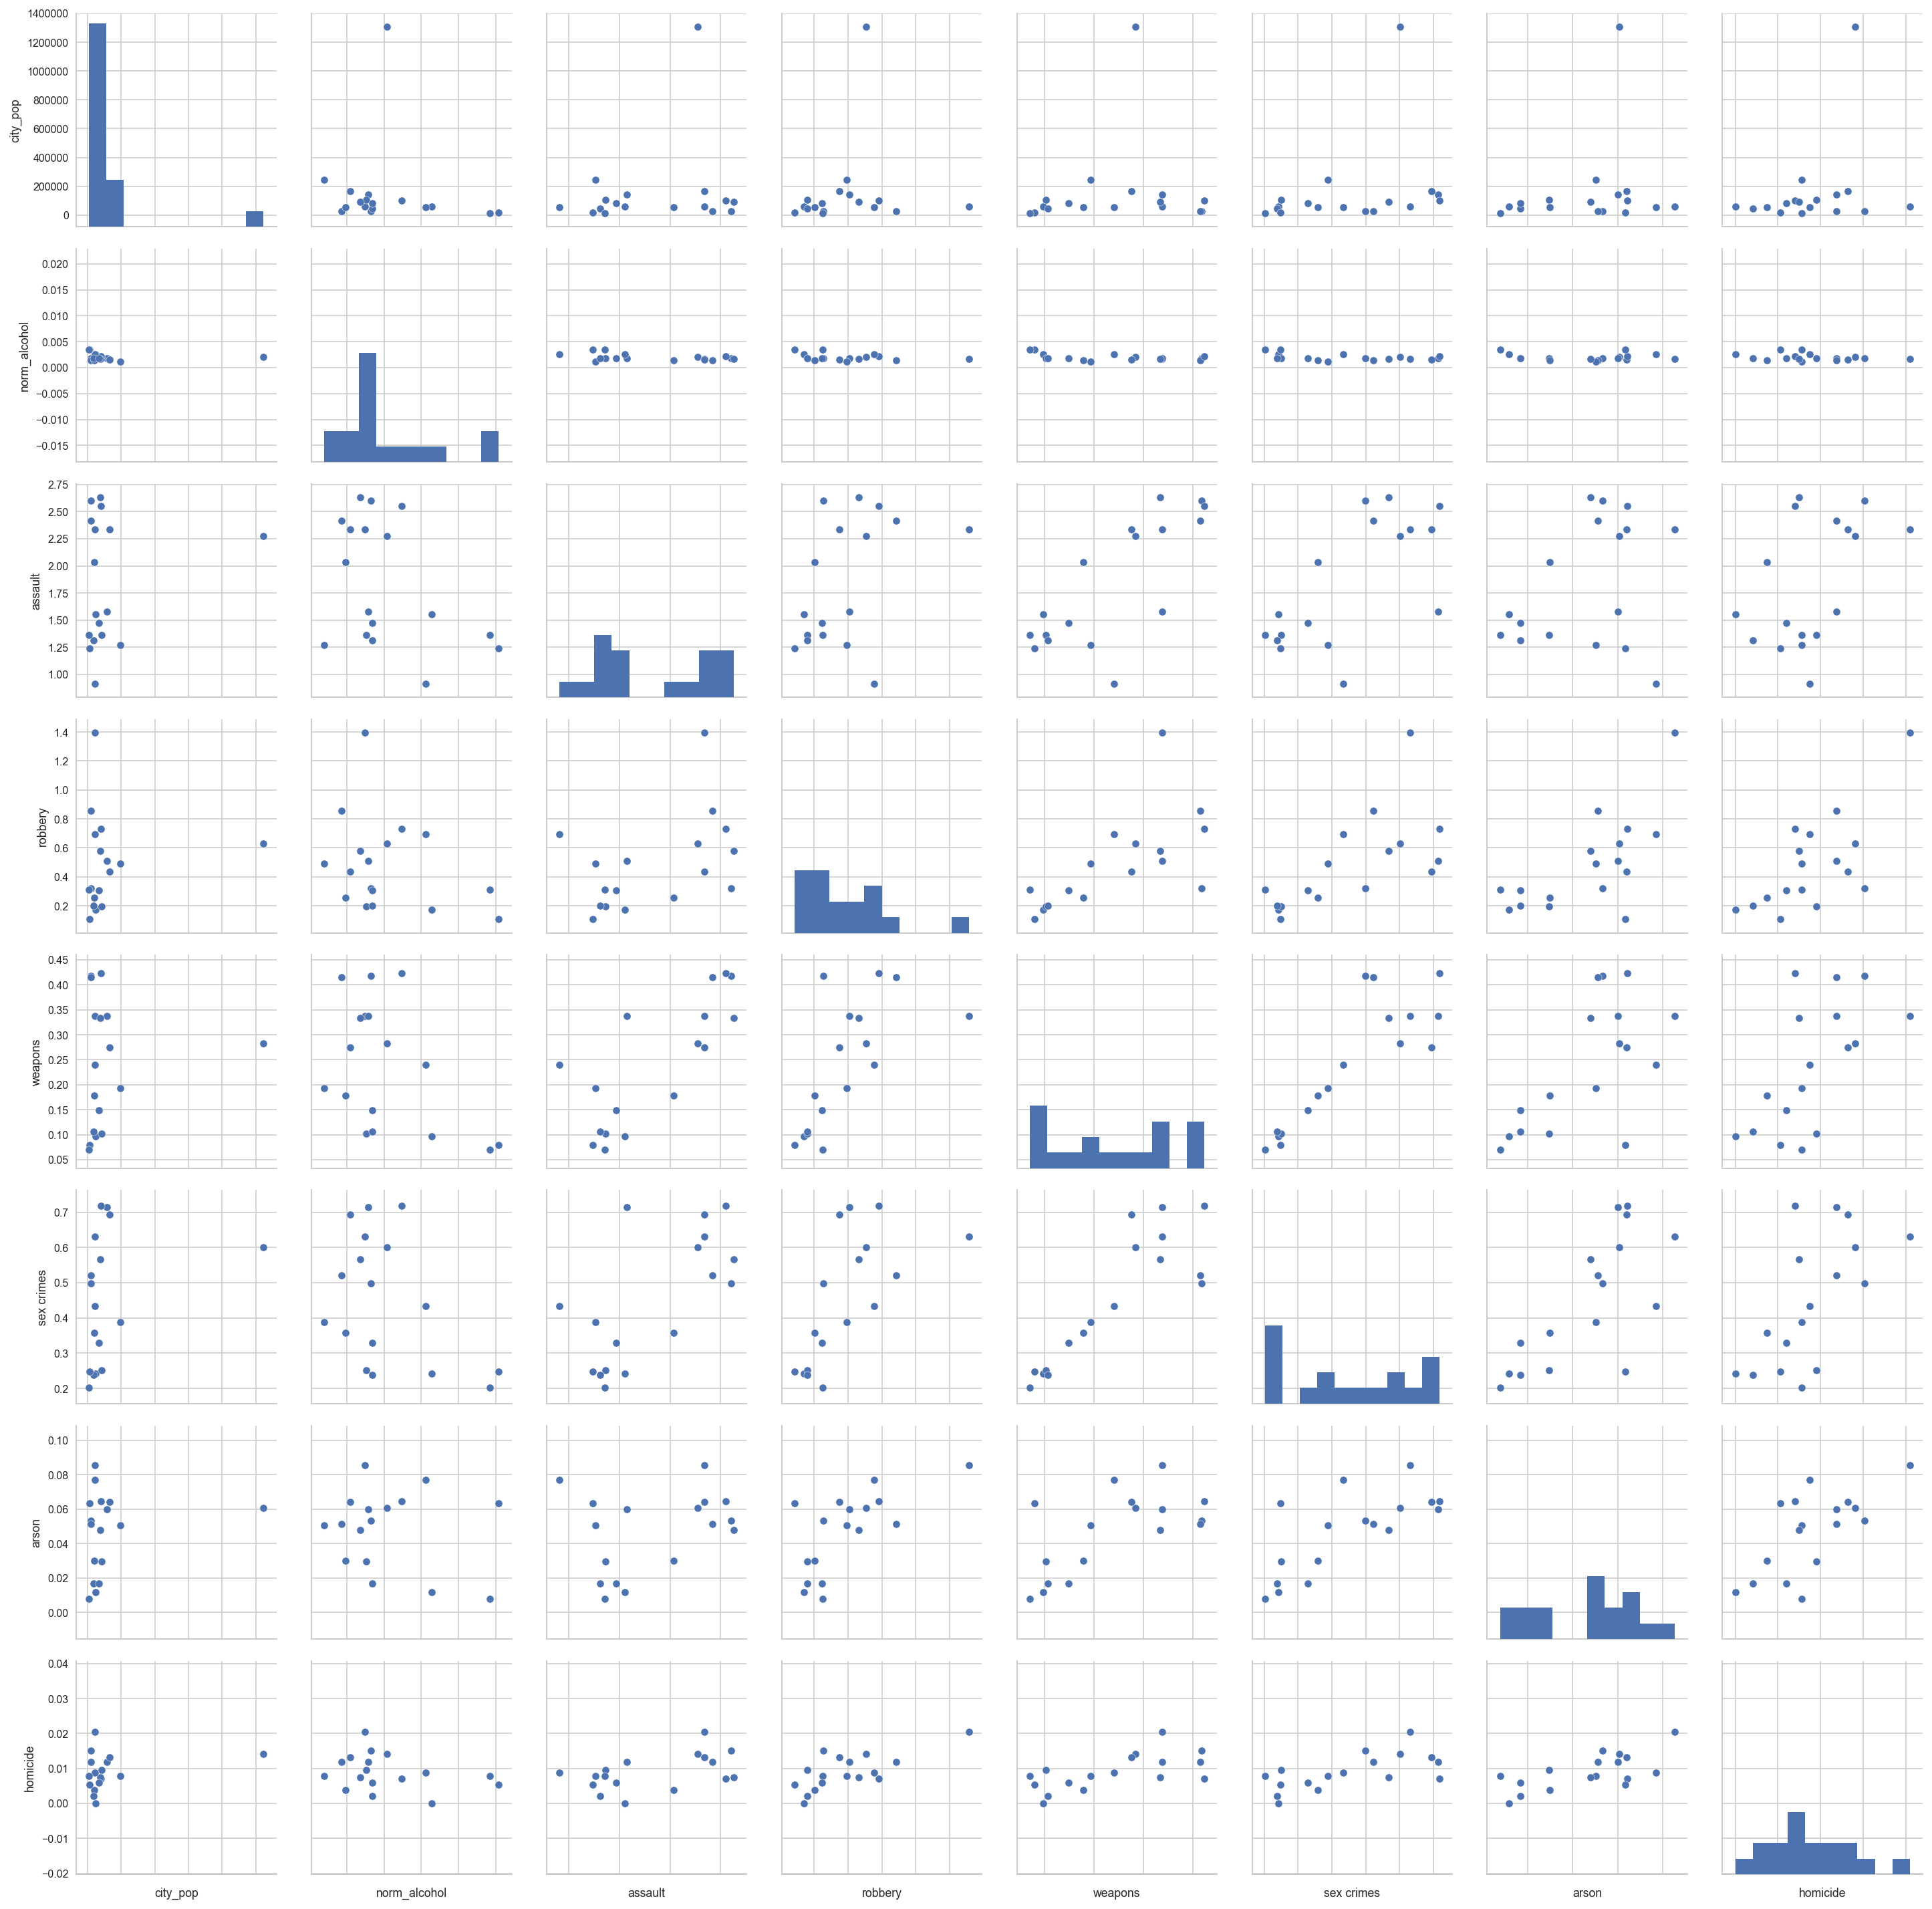

In [34]:
# pretty pairplots for violent crimes

dims = (20,20)
pairplots = sns.pairplot(violent_df)
pairplots.set(xticklabels=[])

In [35]:
# violent crimes analysis on normalized data - Spearman correlation method

# plot the normalized alcohol license counts & normalized crime rates
x3 = violent_df['norm_alcohol']
y3 = violent_df['assault']

violent_df.corr(method="spearman", min_periods=5)

,city_pop,norm_alcohol,assault,robbery,weapons,sex crimes,arson,homicide
city_pop,1.000000,-0.335784,0.156863,0.232843,0.247549,0.534314,0.213235,0.281863
norm_alcohol,-0.335784,1.000000,-0.392157,-0.321078,-0.414216,-0.379902,-0.056373,-0.333333
assault,0.156863,-0.392157,1.000000,0.465686,0.750000,0.651961,0.205882,0.382353
robbery,0.232843,-0.321078,0.465686,1.000000,0.803922,0.767157,0.625000,0.607843
weapons,0.247549,-0.414216,0.750000,0.803922,1.000000,0.872549,0.615196,0.595588
sex crimes,0.534314,-0.379902,0.651961,0.767157,0.872549,1.000000,0.737745,0.615196
arson,0.213235,-0.056373,0.205882,0.625000,0.615196,0.737745,1.000000,0.558824
homicide,0.281863,-0.333333,0.382353,0.607843,0.595588,0.615196,0.558824,1.000000


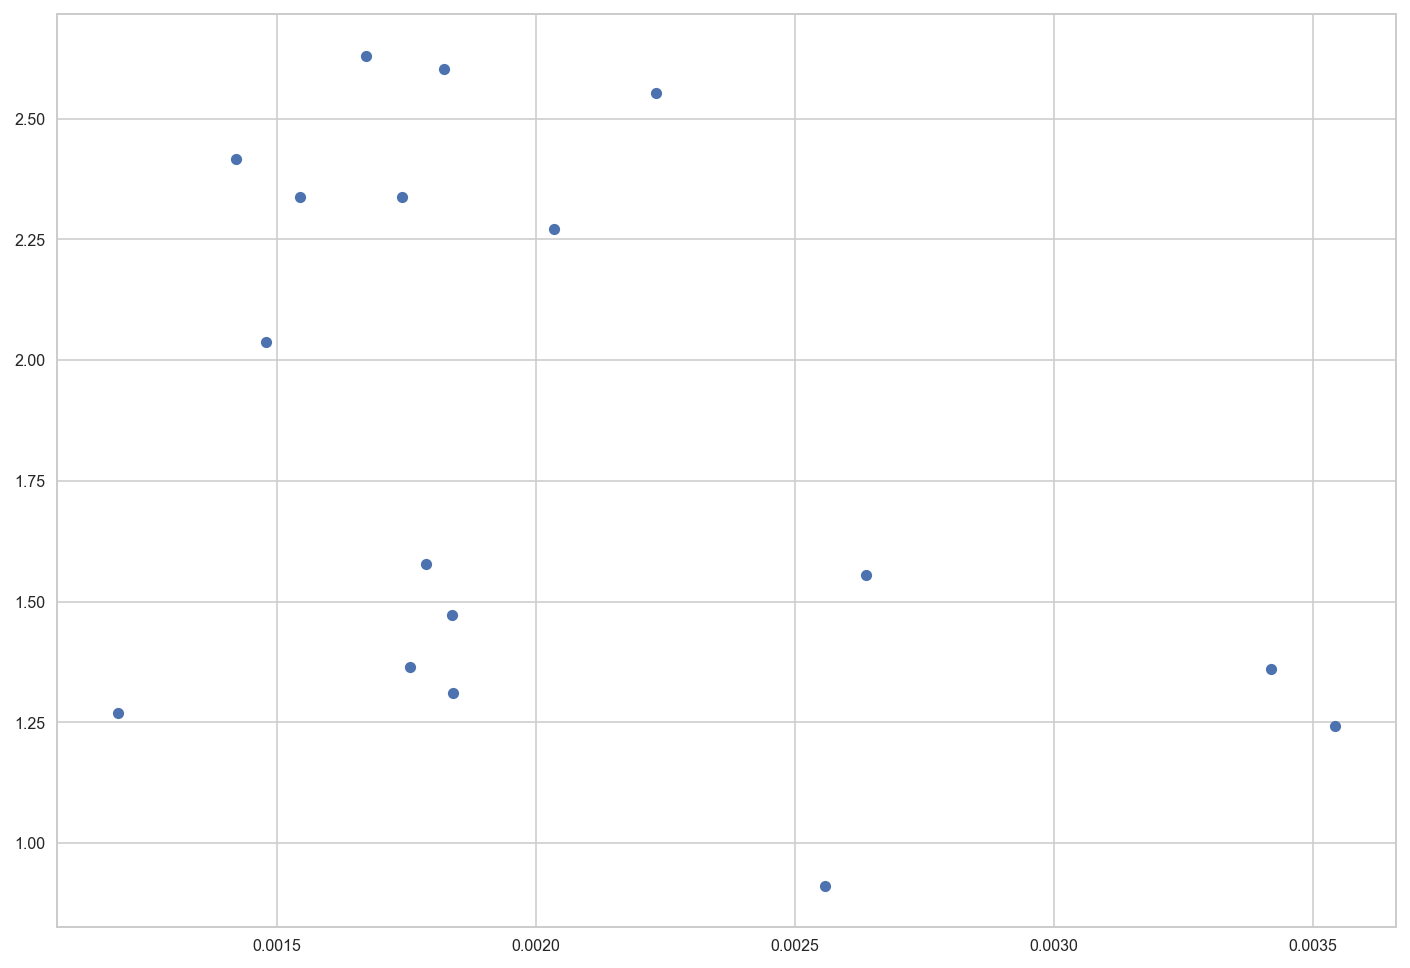

In [36]:
# plot of the cities pre-linear regression computation

plt.figure(figsize=(12,8.4))
plt.plot(x3, y3, "o")

(array([ 4.,  2.,  3.,  1.,  3.,  0.,  1.,  1.,  0.,  2.]),
 array([ -9.24325276e-04,  -5.98233311e-04,  -2.72141346e-04,
          5.39506188e-05,   3.80042584e-04,   7.06134549e-04,
          1.03222651e-03,   1.35831848e-03,   1.68441044e-03,
          2.01050241e-03,   2.33659437e-03]),
 <a list of 10 Patch objects>)

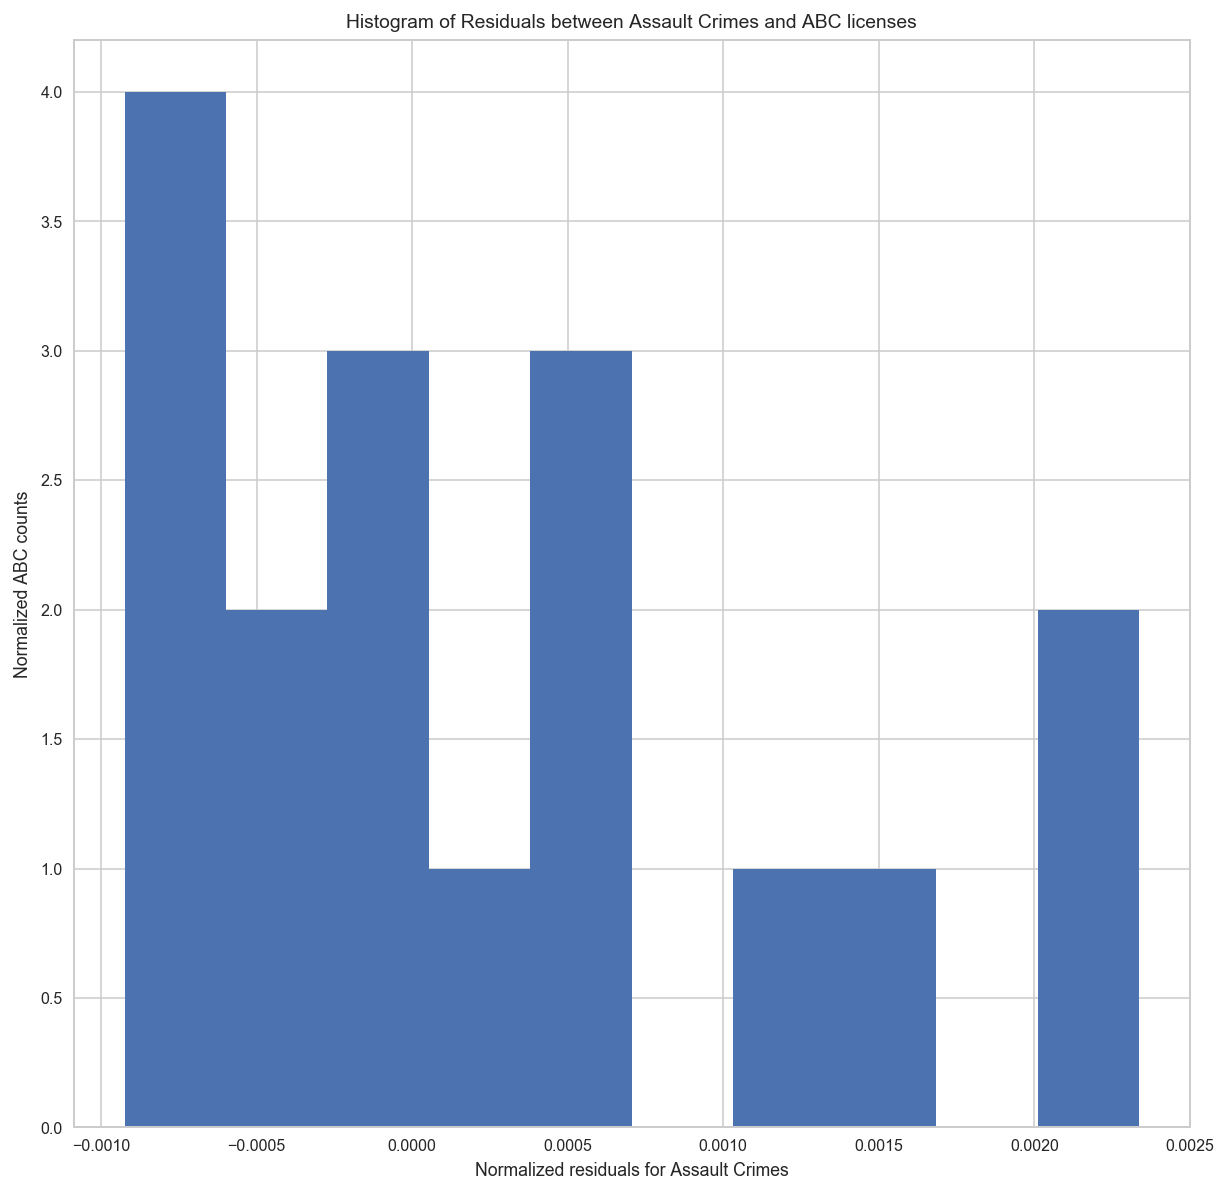

In [37]:
# computing correlation and linear regression model WITHOUT OUTLIER DATA POINT (still Del Mar!)

# checking the distribution/normality of the residuals
model3 = sm.OLS(x3, y3)
fit_to_get_residuals3 = model3.fit()

# histogram of the normalized residuals: how's our distribution?

plt.subplots(figsize=(10,10))
plt.ylabel('Normalized ABC counts')
plt.xlabel('Normalized residuals for Assault Crimes')
plt.title('Histogram of Residuals between Assault Crimes and ABC licenses')
plt.hist(fit_to_get_residuals3.resid)

slope: -362.50906572218946 | intercept: 2.5743430003388084 | correlation coefficient: -0.41463958059303224  | p_value: 0.097952694004611526 | standard error: 205.41732295685267


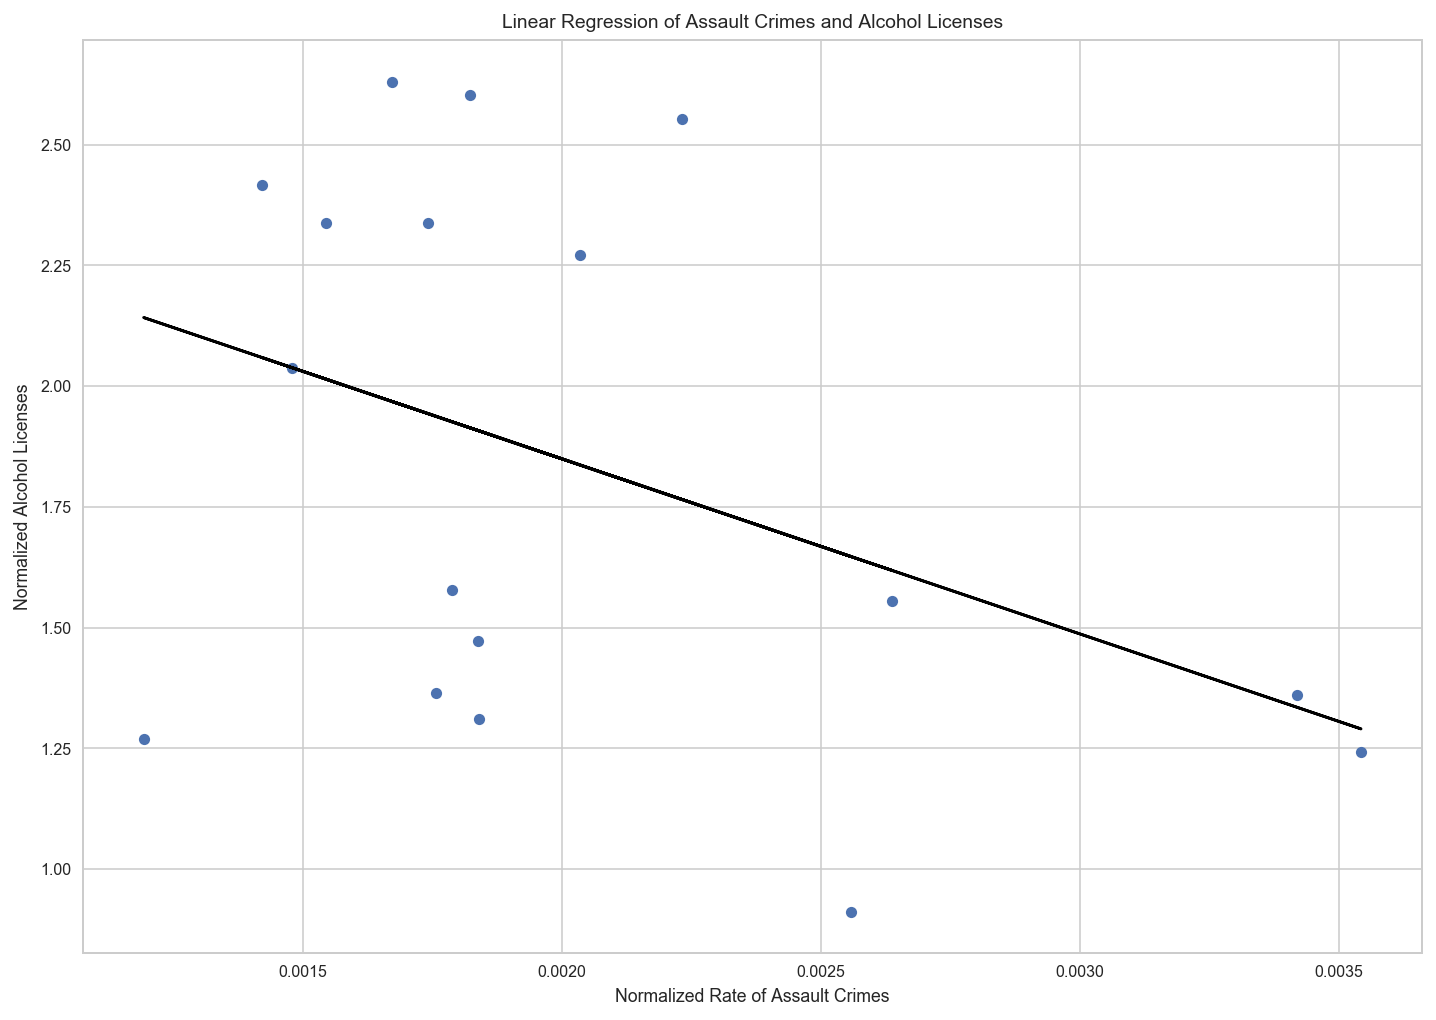

In [38]:
# fit the linear regression without 

slope3, intercept3, corr_value3, p_value3, std_err3 = stats.linregress(x3,y3)

predicted_y3 = intercept3 + slope3 * x3
predicted_error3 = y3 - predicted_y3
degr_freedom3 = len(x3) - 2
residual_std_error3 = np.sqrt(np.sum(predicted_error3 ** 2) / degr_freedom3)

# display the slope, intercept, correlation coefficient, p value, and standard error
display5 = "slope: " + repr(slope3) + " | intercept: " + repr(intercept3) + " | correlation coefficient: " + repr(corr_value3)
display6 = " | p_value: " + repr(p_value3) + " | standard error: " + repr(std_err3)
print(display5, display6)

# plotting linear regression/least squares 
plt.figure(figsize=(12,8.4))
plt.xlabel("Normalized Rate of Assault Crimes")
plt.ylabel("Normalized Alcohol Licenses")
plt.title("Linear Regression of Assault Crimes and Alcohol Licenses")
plt.plot(x3, y3, 'o')
plt.plot(x3, predicted_y3, 'k-')
plt.show()

### Not enough Data Visualization - yet! 

In [39]:
df = pd.read_csv("incidents-100k.csv")

In [40]:
# Let's create a list of lat and lon points from the aggregated data frame
j = 0
points = []
for i in range (len(aggregate_df)):
    latitude = df['lat'][j]
    longitude = df['lon'][j]
    points.append(tuple([latitude,longitude]))
    j = j+1

In [41]:
# Now, let's create a list of lat and lon points for the abc licenses
# As well only keeping points that are inside of the San Diego area
points2 = []
j = 0
df_alcohol = df_alcohol.loc[(df_alcohol["premisesaddress"].str.contains(', SAN DIEGO, CA'))] 

for j, row in df_alcohol.iterrows():
    latitude = row['lat']
    longitude = row['lon']
    points2.append(tuple([latitude,longitude]))


In [42]:
# Getting certain communities  with a similar population
df_Navajo = df.loc[df['community']=='SanNAV']

df_Encanto = df.loc[df['community']=='SanENC']

df_Encanto['comm_pop'].value_counts()

47361    3006
Name: comm_pop, dtype: int64

In [43]:
# Getting the Navajo population
San_NAV_Popu = df_Navajo['comm_pop'].value_counts()


zip_dict = {}
zip_length = len(San_NAV_Popu)
i=0
count = 0
total_population = 0
diff_populations = 0
for i in df_Navajo.index:
    get_NAV_popu=df_Navajo.ix[i, 'comm_pop'] 
    if get_NAV_popu in zip_dict:
        count = (zip_dict.get(get_NAV_popu))+1
        zip_dict.update({get_NAV_popu:count})
    else:
        count = 0
        zip_dict.update({get_NAV_popu:1})
        
for x,y in zip_dict.items():
    total_population = total_population+x
    if x!=0:
        diff_populations +=1
    

final_population = (total_population // diff_populations)

In [44]:
Navajo_population = final_population

In [45]:
# Getting the Encanto population
Encanto_Popu = df_Encanto['comm_pop'].value_counts()


zip_dict2 = {}
zip_length = len(Encanto_Popu)
i=0
count = 0
total_population = 0
diff_populations = 0
for i in df_Encanto.index:
    get_Encanto_popu=df_Encanto.ix[i, 'comm_pop'] 
    if get_Encanto_popu in zip_dict2:
        count = (zip_dict2.get(get_Encanto_popu))+1
        zip_dict2.update({get_Encanto_popu:count})
    else:
        count = 0
        zip_dict2.update({get_Encanto_popu:1})
        
for x,y in zip_dict2.items():
    total_population = total_population+x
    if x!=0:
        diff_populations +=1
    

final_population = (total_population // diff_populations) 

In [46]:
Encanto_population = final_population

In [47]:
# Looking at different crimes in two communities of similar population.
print ('Encanto population:', Encanto_population)
print  ('Navajo population:', Navajo_population)

Encanto population: 47361
Navajo population: 48313


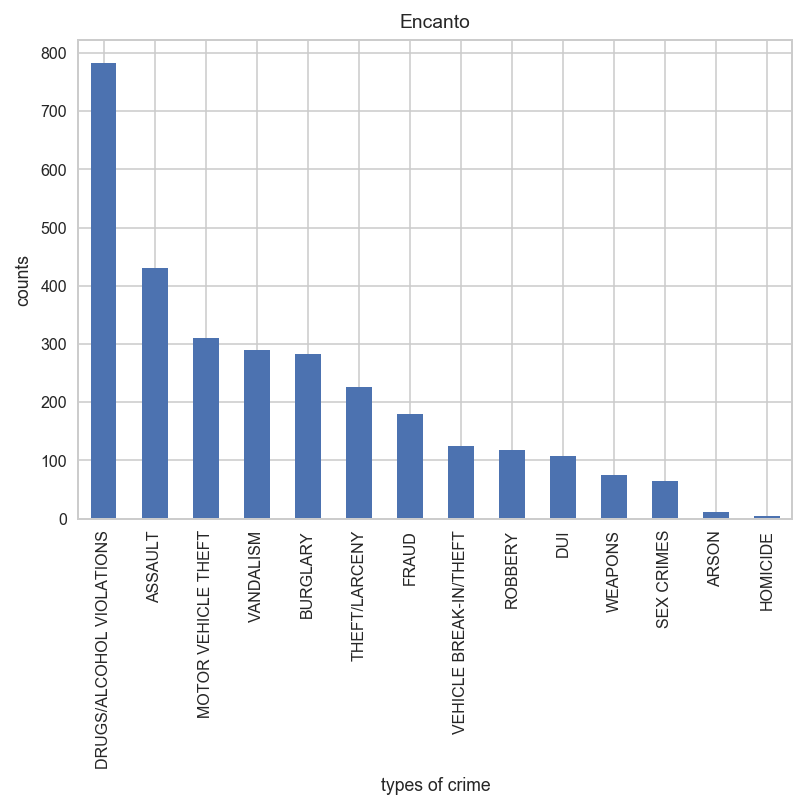

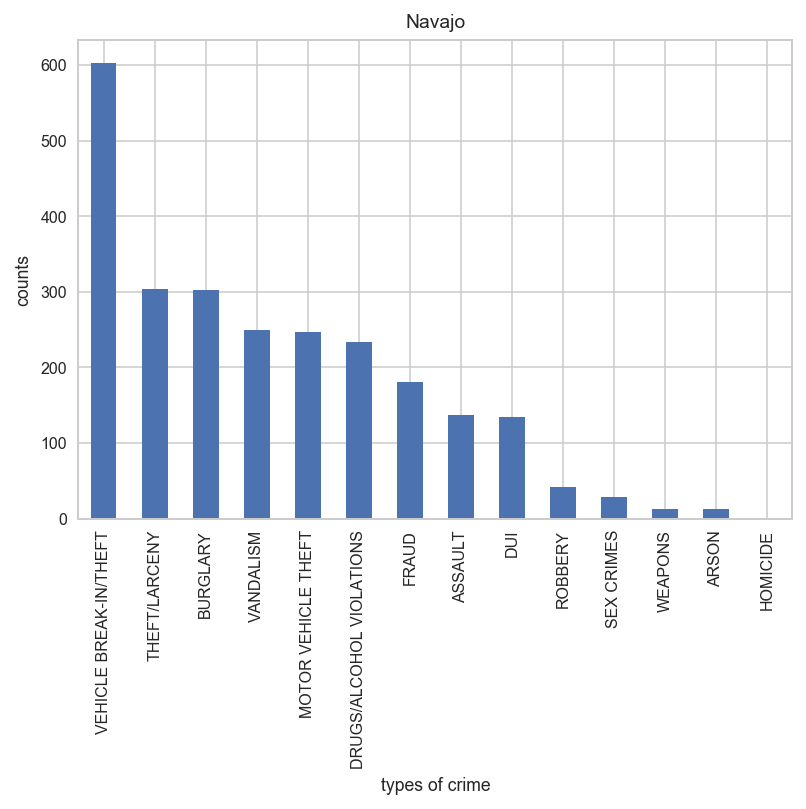

In [48]:
# Now we can look at two communities of similar population
# And how alcohol lead to different crimes in these two areas, and get a better understanding of why that could be
diff_crime_Encanto = df_Encanto['type'].value_counts()
diff_crime_Encanto.plot.bar()
plt.ylabel('counts')
plt.xlabel('types of crime')
plt.title('Encanto')
plt.show()

diff_crime_Navajo = df_Navajo['type'].value_counts()
diff_crime_Navajo.plot.bar()
plt.ylabel('counts')
plt.xlabel('types of crime')
plt.title('Navajo')
plt.show()

In [54]:
# read in the dbf (metadata) file and list all the methods associated with it
import shapefile
sf = shapefile.Reader("ZillowNeighborhoods-CA.dbf")

In [55]:
# Get the metadata for every entry in the dbf file
metadata = sf.shapeRecords()

# This outputs the information that the 38th entry holds 
# (Just to get an understanding of how the file works)
#metadata[38].record

In [56]:
# Find indices of all San Diego neighborhoods
# And insert append them to sd_list
sd_list = []
counter = 0

for i in range(len(metadata)):
    if metadata[i].record[2] == 'San Diego':
        sd_list.append(i)
        counter += 1


In [57]:
# Create a list and append all shape points to it, this holds the outline/ boundary of California
shapes = sf.shapes()
sd_shapes = []

for i in range(len(sd_list)):
    sd_shapes.append(shapes[sd_list[i]].points)

for i in range(len(sd_shapes)):
    for j in range(len(sd_shapes[i])):
        sd_shapes[i][j] = sd_shapes[i][j][::-1]


In [58]:
read_shapemeta=shapefile.Reader('ZillowNeighborhoods-CA.dbf')
shapemeta = read_shapemeta.shapeRecords()


sorted_SD_list = []


# metadata[i].record[2] holds the city name, thus we filter through the whole California shape file for San Diego cities only
for i in range(len(shapemeta)):
     if metadata[i].record[2] == 'San Diego':
        sorted_SD_list.append(shapemeta[i].record[3])
sorted_SD_list = sorted(sorted_SD_list)   

In [59]:
# determine the population rate per city and save in a new dataframe df_stats
df_stats = df[['community','comm_pop']].drop_duplicates()

# add a column 'crime' to df_stats that represents the raw count of crimes for that community 
# (raw counts are determined by the number of rows containing the community )
df_stats['crime'] = df.groupby('community')['community'].transform('count')

# add a column 'crimerate' to df_stats to normalize for the population
df_stats['crimerate'] = df_stats['crime'] / df_stats['comm_pop']

#use data from df_stats to get a dictionary where the keys are the community names and the values are the crime rates
dict_crimerate = df_stats[['community', 'crimerate']].set_index('community')['crimerate'].to_dict()

# remove outlier: community with lower population than crime
df_stats = df_stats[df_stats['comm_pop'] > df_stats['crime']]

# Get max and min ratio of the 
max_ratio = (max(df_stats['crimerate']))
min_ratio = (min(df_stats['crimerate']))

# We will use this as incremental values
one_fifth = (max_ratio/5)

sorted_df_stats = sorted(df_stats['crimerate'])

In [60]:
# lat and lon, along with zoom will help us close in on San Diego on the map
j = 0
lat = 32.7157
lon = -117.1611
zoom_start = 11

# This initializes our map start location, zoom, and type of map
m = folium.Map(location=[lat, lon], zoom_start=zoom_start,tiles='Stamen Toner')

# We will keep plotting points based on the smaller dataset
if (len(points)<(len(points2))):
    length=(len(points))
else:
    length=(len(points2))
for i in range(length):
    coord_2 = points2[j]
    
    # Plot points of the abc licenses
    kw2 = dict(fill_color='black' ,radius=4)
    c1 = folium.CircleMarker(coord_2, **kw2)
    for c in [c1]:
        m.add_child(c)
    j=j+1

    

# Using the shape file as a boundary for San Diego
# We broke up the ratio into five portions, and if it fell into a certain range
# it would be a certain color, and the higher the ratio, the darker the color
# We multiplied the ratios by 100, to help with incrementation, and increased by the previous (1/5) incremental value
j=0
df_stats_length = len(df_stats)
for c in range(len(sd_shapes)):  
    
    
    if c <=(sorted_df_stats[10]*100):
        colour = '#f0f9e8'        #Transparent color
    if c >(sorted_df_stats[10]*100) and c<=(sorted_df_stats[20]*100):
        colour = '#bae4bc'         # green color
    if c >(sorted_df_stats[20]*100) and c<=(sorted_df_stats[30]*100):
        colour = '#7bccc4'          # Cyan color
    if c >(sorted_df_stats[30]*100) and c<=(sorted_df_stats[40]*100):
        colour = '#43a2ca'           # Blue color
    if c >(sorted_df_stats[40]*100) and c<=(sorted_df_stats[df_stats_length-1]*100):
        colour = '#0868ac'           # Dark blue
    if c>(df_stats_length) and c<=(len(sd_shapes)):
        colour = 'white'

    j=j+1
    # hood_line will draw the boundary based on the shape file of San Diego
    hood_line = folium.features.PolygonMarker(locations=sd_shapes[c], color='pink', fill_color=colour, weight=3)
    m.add_child(hood_line)


![Choropleth screenshot for git](Pr_009-master/Choropleth.png)


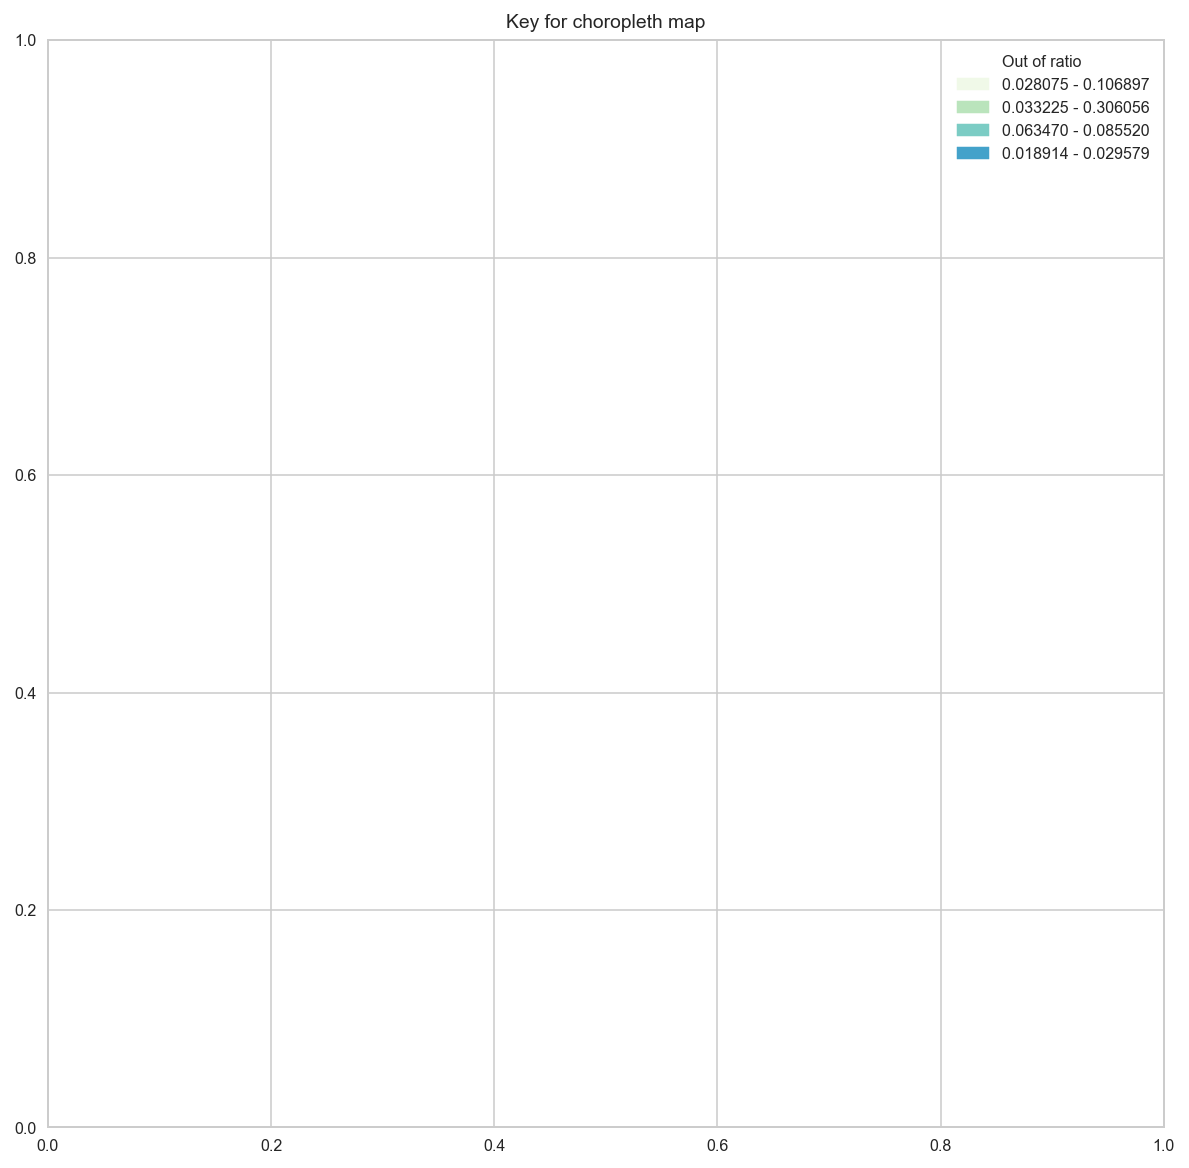

In [61]:
# A key for our map
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10,10))
colour_1 = mpatches.Patch(color = 'white', label = 'Out of ratio')
colour_2 = mpatches.Patch(color='#f0f9e8', label='0.028075 - 0.106897')
colour_3 = mpatches.Patch(color='#bae4bc', label='0.033225 - 0.306056')
colour_4 = mpatches.Patch(color='#7bccc4', label='0.063470 - 0.085520')
colour_5 = mpatches.Patch(color='#43a2ca', label='0.018914 - 0.029579')
colour_6 = mpatches.Patch(color='#0868ac', label='0.022333 - 0.021948 ')
plt.title("Key for choropleth map")
plt.legend(handles=[colour_1,colour_2,colour_3,colour_4,colour_5])

plt.show()

### Results! 
Initially, in including the city of Del Mar in our analysis, it seemed certain that there was a positive correlation between ABC permits and overall crime rates (p-value=3.09806899582e-05). However, upon removing Del Mar, lo and behold, our p-value shot up to 0.918964990026! Evidently, we should hang on to our null hypothesis that there is no association between overall crime and alcohol availability...

We decided to perform a similar analysis between "Assault" typed crimes and alcohol permits counts by city (without pesky Del Mar) with the thought that alcohol could be associated with more violent-specific crimes. Nevertheless, though the linear regression analysis appears to demonstrate a significant negative correlation between the two, we had a p-value ~= 0.097952. We thus can't say anything "positive" about that, either! Hence, we conclude that alcohol does not correlate with overall crime rates, nor with the rate of "Assault" crimes.

### Discussion!
#### Future Ideas and Biases to Keep in Mind
There are several confounds and biases in our data sources and analyses. For one, our datasets simply tell us where an ABC license is located. The mere existence of a license, however, does not necessarily translate to how much it is used. It does not inform us how often the resource is frequented by the community, as well as how well-managed the resource. For example, there may be three bars in a single city, and one bar, which is extremely popular and conducts far more business than the other three, in a different city. In short, quanitity does not necessarily imply usage.  

As for our analyses, one pitfall is that we treat cities as independent entities. In other words, when we examine crime in a city, we only examine the licenses in that very same city. We do not look at the licenses of neighboring cities when deriving our results. The drawback is that there may be bars and shops which are actually shared among nearby cities, so that multiple regions benefit from them. As it is difficult to take accessibility and openess of a license into account, we do hope that this issue is minor. 

For the future, we hope to categorize the crimes rates and number of ABC licenses in different, more granular ways (such as by neighborhoods and communities) instead of just cities. Using the geocoder package from Google, it may be possible to obtain these results- though it will be computationally expensive. We also can look more closely at ABC license locations themselves. We can perhaps get a gauge of a location's popularity through using the wisdom of the crowds- one idea is web scraping reviews from online. Another, more realistic idea is to do text mining of the location names. A pizza restuarant that serves wine, for example, may very well have a different affect on crime than a liquor store. Once we group the ABC license locations into their appropriate categories (such as family restauarnt, store, bar), we can then perform the similar analyses to get the correlation coefficients. It is possible that the reason we discovered there was very little correlation between ABC license locations and crime rates is that different types of locations had a different effect on crime. If time permits, we may even expand our analyses to different types of amenities and services (such as the presence of hospitals, restaurants, grocery shops, and prisons) and see how those are correlated with the crime rates.

### Teaser! A random sampling of crime in the City of San Diego by Community and Type

In [62]:
# 100k random incidents? put'er in: df

df = pd.read_csv("incidents-100k.csv")

In [63]:
# first, clean that data: remove any rows that do not have a community specified, or community population

# print(df.shape)
df = df[df['community'] != 'NONE']
# print(df.shape)
df = df[df['comm_pop'] != 0]
# print(df.shape)

In [64]:
# get the community populations and rates of crimes (normalized by pop)

counts_by_community = df['community'].value_counts()
counts_by_pops = df['comm_pop'].value_counts()

comm_dict = counts_by_community.to_dict()
# print(comm_dict)
pops_dict = counts_by_pops.to_dict()
# print(pops_dict)

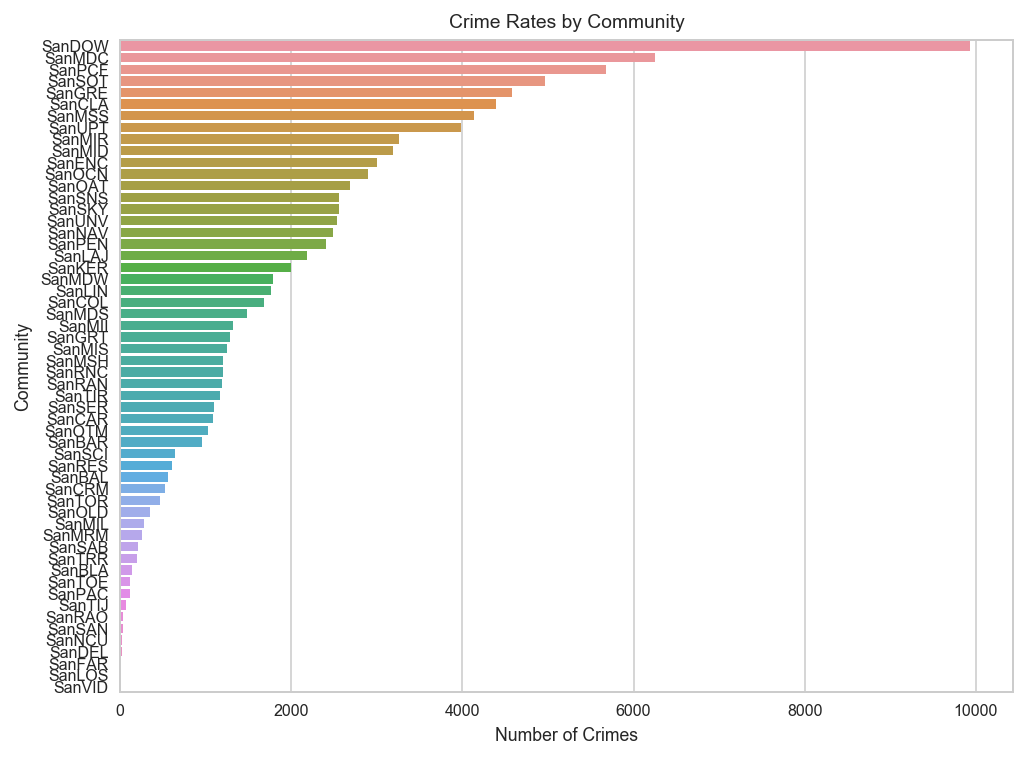

In [65]:
# a lovely plot o' crime - by community 

dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
axes = sns.barplot(ax=ax, x=counts_by_community, y=counts_by_community.index)
axes.set(xlabel="Number of Crimes", ylabel="Community", title="Crime Rates by Community")
sns.plt.show()

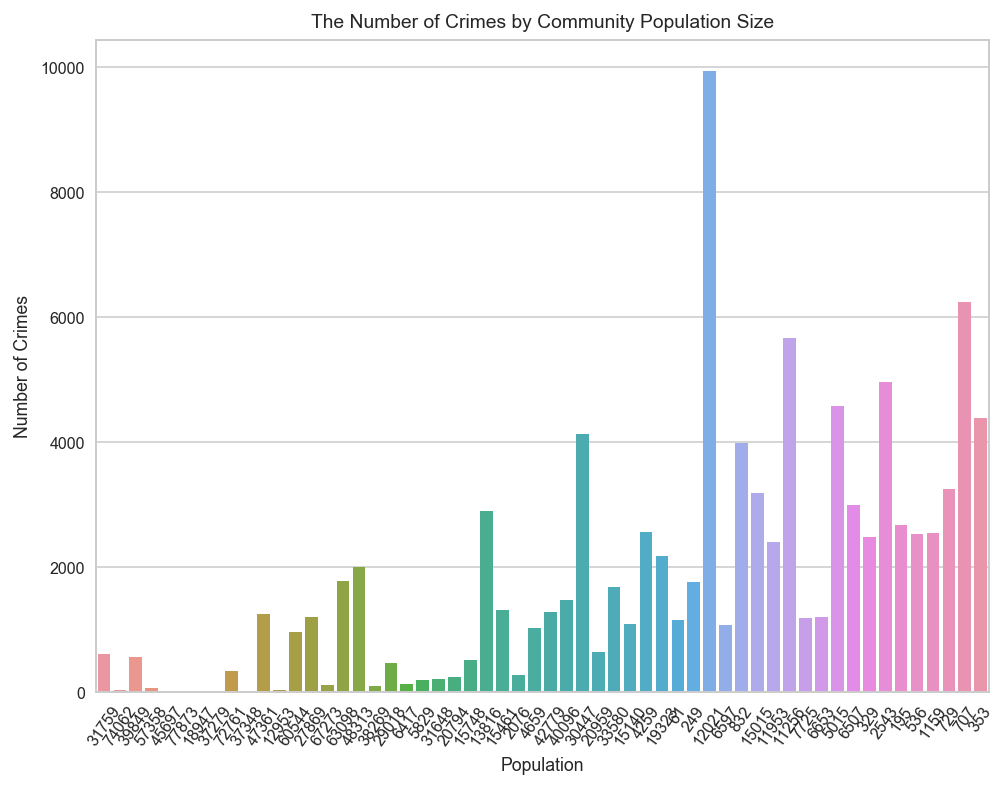

In [66]:
# bar plot of the number of crimes by population counts

dims = (8, 6)
fig, ax = plt.subplots(figsize=dims)
bargraph = sns.barplot(x=counts_by_pops.index, y=counts_by_pops)
bargraph.set_xticklabels(labels=counts_by_pops.index, rotation=55)
bargraph.set(xlabel="Population", ylabel="Number of Crimes", title="The Number of Crimes by Community Population Size")
sns.plt.show()

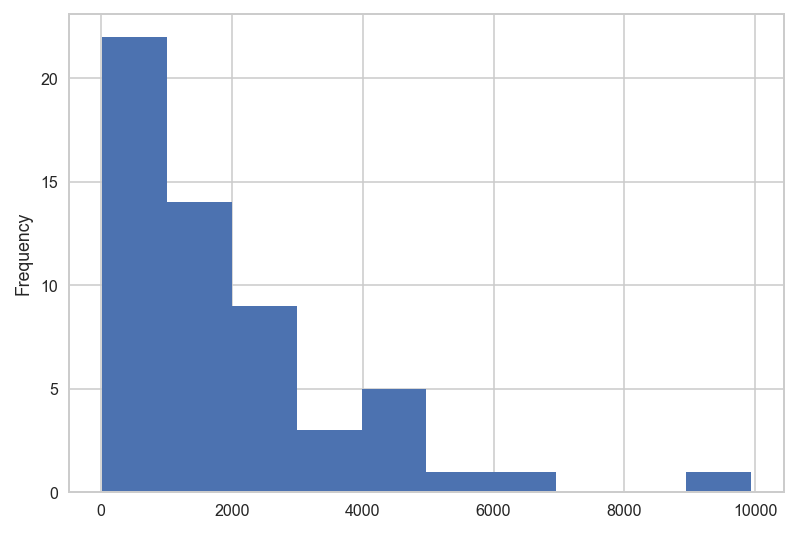

In [67]:
# plot of incident counts by community population (histogram)

counts_by_community.plot(kind="hist")
f2 = plt.show()
f2 = plt.gcf()

In [68]:
# determine the population rate per city and save in a new dataframe df_stats
df_stats = df[['community','comm_pop']].drop_duplicates()

# add a column 'crime' to df_stats that represents the raw count of crimes for that community 
df_stats['crime'] = df.groupby('community')['community'].transform('count')

# add a column 'crimerate' to df_stats to normalize for the population
df_stats['crimerate'] = df_stats['crime'] / df_stats['comm_pop']

#use data from df_stats to get a dictionary where the keys are the community names and the values are the crime rates
dict_crimerate = df_stats[['community', 'crimerate']].set_index('community')['crimerate'].to_dict()

# remove the outlier: community with lower population than crime
df_stats = df_stats[df_stats['comm_pop'] > df_stats['crime']]
# print(df_stats)

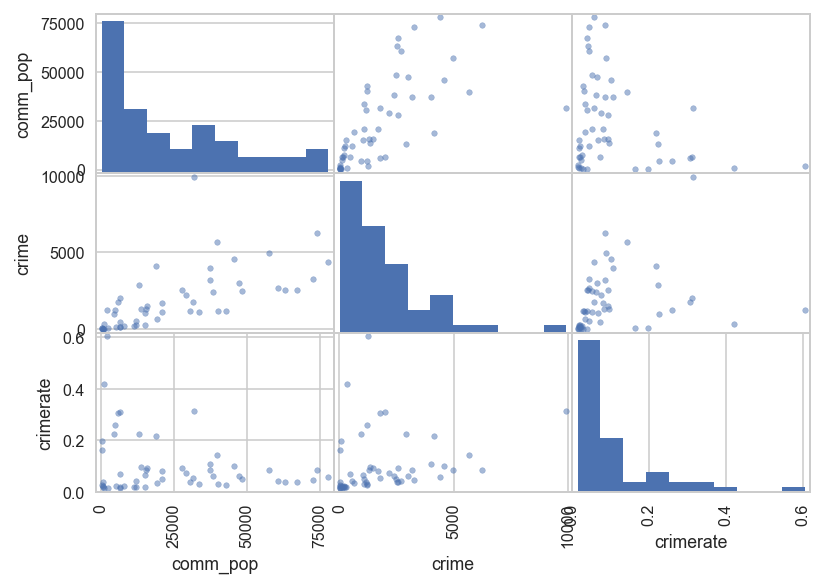

In [69]:
# a scatter matrix of the normalized crime rates (by population)

fig = pd.scatter_matrix(df_stats)

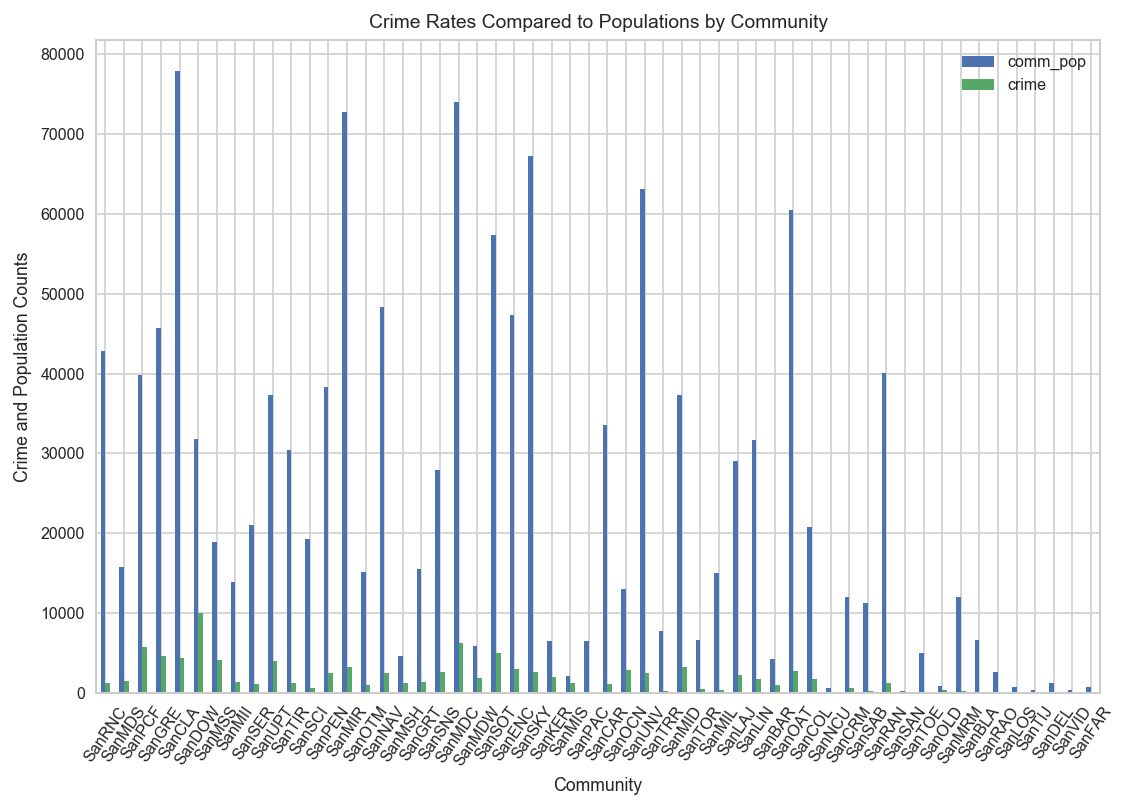

In [70]:
# plot the total crime and population counts per community

axes = df_stats[['community', 'comm_pop', 'crime']].plot.bar(figsize=(9,6))
axes.set_xticklabels(labels=df_stats.community, rotation=55)
axes.set(xlabel="Community", ylabel="Crime and Population Counts", title="Crime Rates Compared to Populations by Community")

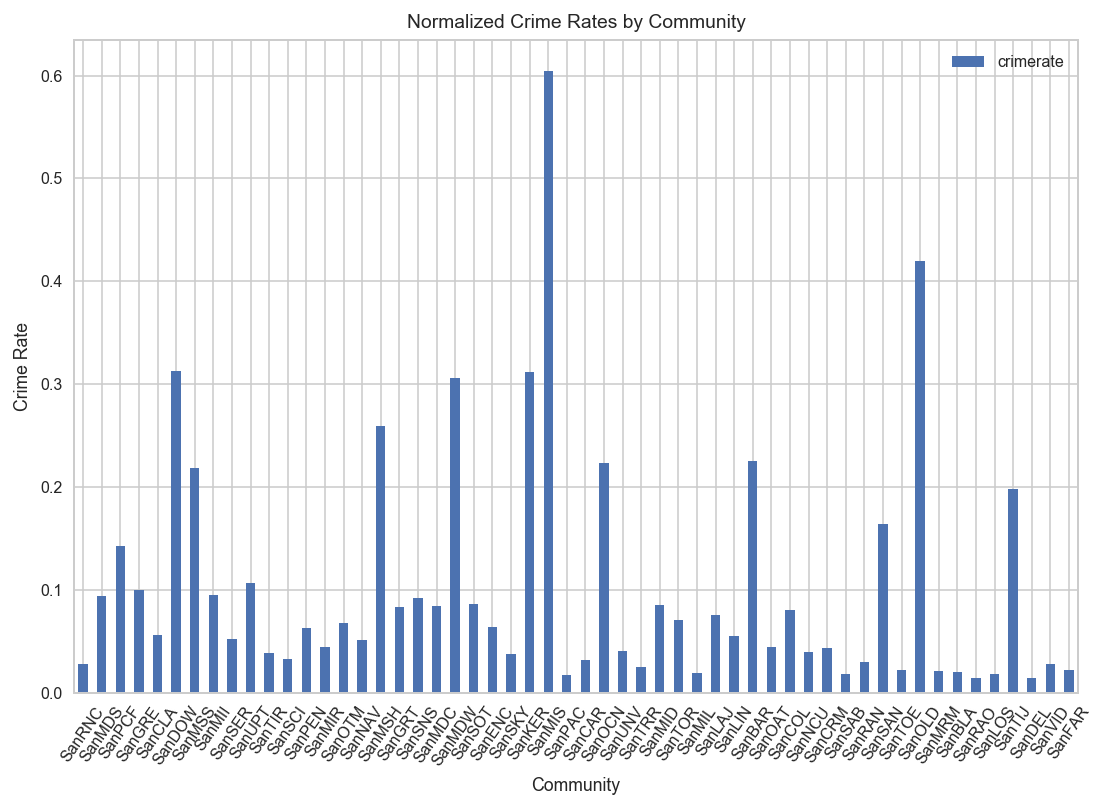

In [71]:
# normalized crime rates by city

axes = df_stats[['community', 'crimerate']].plot.bar(figsize=(9,6))
axes.set_xticklabels(labels=df_stats.community, rotation=55)
axes.set(xlabel="Community", ylabel="Crime Rate", title="Normalized Crime Rates by Community")

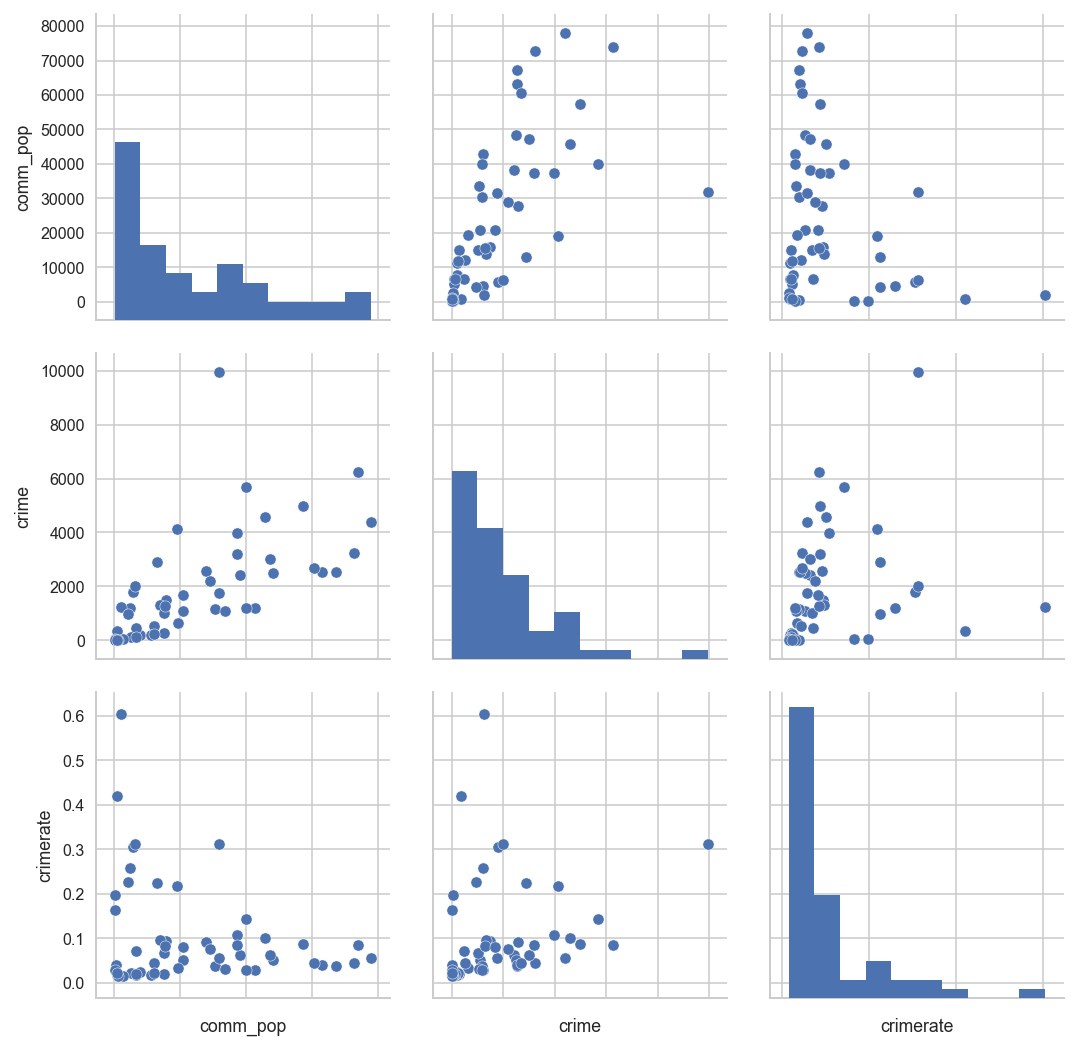

In [72]:
# pairplots of population size to number of crime incidents

pairplots = sns.pairplot(df_stats)
pairplots.set(xticklabels=[])

,comm_pop,crime,crimerate
comm_pop,1.000000,0.653189,-0.248275
crime,0.653189,1.000000,0.227748
crimerate,-0.248275,0.227748,1.000000


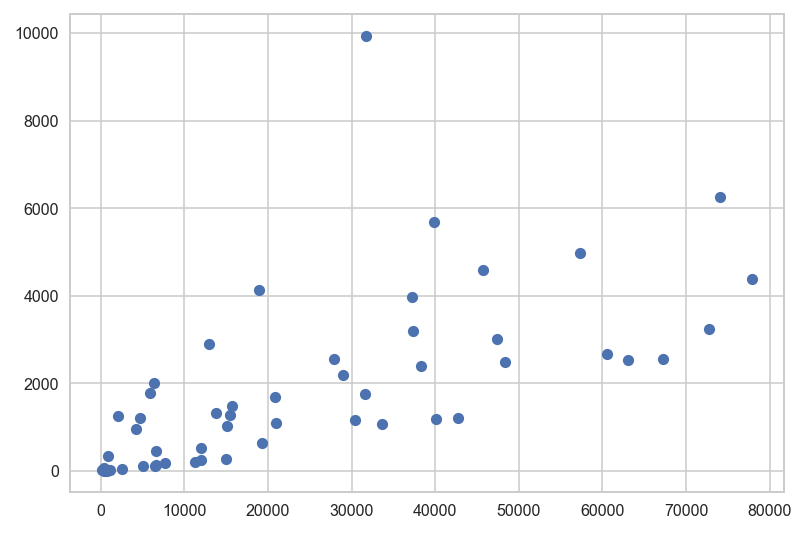

In [73]:
# does population increase the rate of crime in a community? let's find out

x = df_stats['comm_pop']
y = df_stats['crime']
plt.plot(x, y, "o")
df_stats.corr()

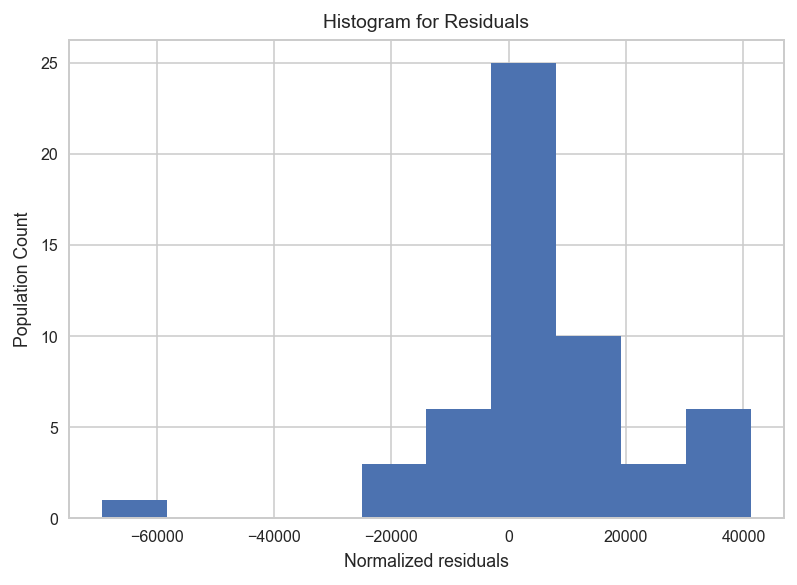

In [74]:
# checking the distribution/normality of the residuals
model = sm.OLS(x, y)
fit_to_get_residuals = model.fit()

# histogram of the normalized residuals: how's our distribution?
plt.hist(fit_to_get_residuals.resid)
plt.ylabel('Population Count')
plt.xlabel('Normalized residuals')
plt.title('Histogram for Residuals')

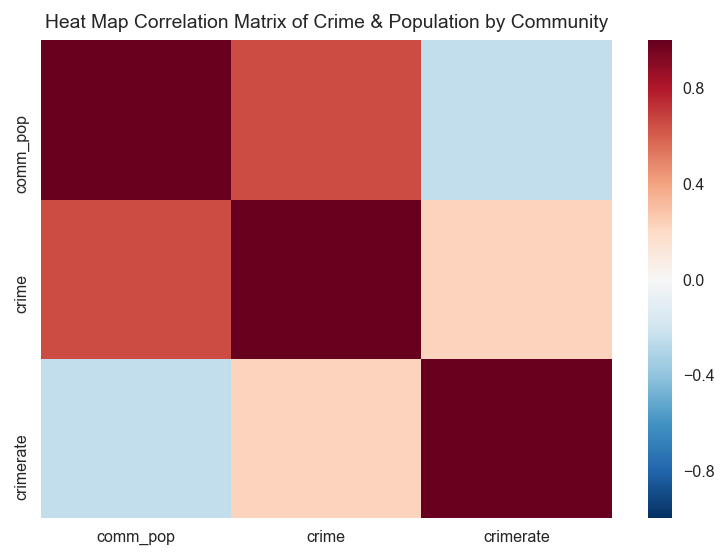

In [75]:
# well, looks like it does! but not by as much as one might expect...
# let's check out a heatmap - correlation matrix - of crime to population by community

crime_corr = df_stats.corr()
crime_heatmap = sns.heatmap(crime_corr, 
            xticklabels=crime_corr.columns.values,
            yticklabels=crime_corr.columns.values)
crime_heatmap.set(title='Heat Map Correlation Matrix of Crime & Population by Community')